# Proejct Milestone 2: EDA
## NHIS Mental Health Dataset 

**Author:** Surbhi Kapoor  
**Date:** 2025-10-04  
**Dataset Citation:** [National Center for Health Statistics. National Health Interview Survey, 2024 survey description. 2025.](https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2024/srvydesc-508.pdf)

__Other Resources__: 

[General Dataset CDC Page](https://www.cdc.gov/nchs/nhis/documentation/2024-nhis.html)

## Problem Statement and Background
I took the feedback from the last few assignments on refining the research question and based on a little bit of exploring of the dataset the question I want to answer and also gives me the opportunity to explore feature, categories of features, clusters of profiles and in general insight into mental health predictor features. 

**Research Question**: <font color="magenta">Can a machine learning model using baseline demographic, behavioral, and social factors predict future psychological distress (K6 ≥ 5) with ≥70% accuracy, and identify the most important modifiable risk factors for early intervention?</font>

As I mentioned in earlier literature this predicive model will also encompass the analysis and building of profiles, clusters and feature analysis that will give us a lot of insight into mental health indicators as we go along with the problem. I belieeve it is an interesting problem because despite the jump in increased accesibility and improved healthcare for mental health it has now started to edge on misinformation and misdiagnosis. Sometimes hinting towards favoring a bigger unimportant scheme like the pharamacutical industries. This study is an attempt to breakdown the very clear social, demographic, economic and other tangible features that are identifiable in a persons life to be able to help them get not just a diagnosis but a personalized guidance on preventative or towards helping themselves.
The accesibiity of the data features is what draws me most to this kind of dataset. While there is a lot of literature not for mental health and correlation features it rarely comes about in survey form on such a scale ( and public use is a huge plus too; even if it a significant sample set and not complete) such that we can easily collect these feature values for a participant and get a prediction value without having to collect bloodtests, family history and other such meticulous reportings. 

## Dataset 

The dataset used in this analysis comes from the 2024 National Health Interview Survey (NHIS), conducted by the National Center for Health Statistics (NCHS), part of the Centers for Disease Control and Prevention (CDC). The NHIS is the principal source of information on the health of the U.S. civilian noninstitutionalized population and has been conducted continuously since 1957.
Full Dataset Specifications:

- Total Sample Size (2024 NHIS): 32,629 Sample Adults
- Response Rate: 47.9% (final adult response rate)
- Survey Mode: 53.2% telephone interviews, 46.8% face-to-face interviews
- Public Use File: 630 variables covering demographics, health status, chronic conditions, healthcare access, health behaviors, and mental health indicators.

I will be using the entire sample set for my analysis and as I go through maybe filter and drop features that are unimportant and/or redundant. Since there are 630 variables there is a whole separate codebook that defines all the column codes and their descriptions. I used this and CLaude as my personal parser to create a script that helps scrape the codebook and map all features to jsons containing the column codes as readable english names. This is goign to be very helful in the EDA and final reporting stages with ambiguous features being converted to understandable natural language. There is alot more statitiscal summarying and information about data collection that I think is redundant to include here considering that NHIS has taken the time to already compile an overview document for this as well. I have linked all of these relevant sources below that may or may not be included in my submission file as well. 

**For clarity sake and clean outputs I will use certain categories / themes of variables to see their distributions and demographics for better insight into the dataset. These will also be included in modelling and are those variables that are according to me most important and interpretable for analysis.**

### Issues 
The biggest and most glaring issue I faced was the volume of features that without data science tools are too hard to manually go through and keep track of. That being said even though I mentioned well mentioned documentation it is also voluminous and that combined with my lack of domain knowledge makes it hard for me to without analysis trim down to important features only. The other issue I spent time over and probably might update in the future is the research question target variables. The definition of good /bad and fair are subjective to the features in the dataset as well as my understanding of the topic. I will do my best to make this a significant study and do thorough research as I build the project out. 


**_Sources_**:

Dataset: https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2024/

Codebook: https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2024/adult-codebook.pdf

Survey Description: https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2024/srvydesc-508.pdf

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('flare')

## Load Variable Dictionary

This dictionary maps NHIS variable codes to human-readable names for visualization.

In [73]:
def load_variable_dictionary():
    """Load NHIS variable dictionary for readable names"""
    try:
        with open('nhis_variable_dictionary.json', 'r') as f:
            var_dict = json.load(f)
        print(f"✓ Dictionary loaded: {len(var_dict)} variables mapped")
        return var_dict
    except FileNotFoundError:
        print("⚠ Warning: Variable dictionary not found.")
        print("Run the dictionary creator script first, or continue with original names.")
        return {}

## 1. Load and Explore Data

In [76]:
# Load dataset
df = pd.read_csv('adult24.csv')

print(f"Dataset shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]:,}")
print(f"\nFirst few columns: {list(df.columns[:10])}")

Dataset shape: (32629, 630)
  Rows: 32,629
  Columns: 630

First few columns: ['RATCAT_A', 'INCTCFLG_A', 'IMPINCFLG_A', 'PPSU', 'PSTRAT', 'WLKLEISTC_A', 'WLKTRANTC_A', 'HISPALLP_A', 'RACEALLP_A', 'ANYDIFF_A']


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32629 entries, 0 to 32628
Columns: 630 entries, RATCAT_A to POVRATTC_A
dtypes: float64(401), int64(227), object(2)
memory usage: 156.8+ MB


In [78]:
# I will conert column names so I can understand what is going on 
def get_readable_name(code, var_dict):
    """Get readable name for a variable code"""
    return var_dict.get(code, code)

def format_column_names(df, columns, var_dict):
    """Create a mapping of original to readable names for given columns"""
    return {col: get_readable_name(col, var_dict) for col in columns}

# Load the dictionary
var_dict = load_variable_dictionary()

fatigue_vars = {
    'FGEFRQTRD_A': 'Fatigue: Frequency of feeling tired/exhausted (past 3 months)',
    'FGELNGTRD_A': 'Fatigue: Duration of tiredness periods',
}

# Update your dictionary
var_dict.update(fatigue_vars)

✓ Dictionary loaded: 363 variables mapped


After parsning and summarizing a lot of documents here are the categoricals decoded for better visualizations

In [80]:
value_labels = {
    'SEX_A': {1: 'Male', 2: 'Female'},
    
    'HISPALLP_A': {
        1: 'Hispanic',
        2: 'NH White',
        3: 'NH Black',
        4: 'NH Asian',
        5: 'NH AIAN',
        6: 'NH AIAN+Other',
        7: 'Other/Multiple'
    },
    
    'EDUCP_A': {
        1: 'Grade 1-11',
        2: '12th, no diploma',
        3: 'GED',
        4: 'HS Graduate',
        5: 'Some college',
        6: 'Assoc (voc)',
        7: 'Assoc (acad)',
        8: "Bachelor's",
        9: "Master's",
        10: 'Prof/Doctoral'
    },
    
    'MARITAL_A': {
        1: 'Married',
        2: 'With partner',
        3: 'Widowed',
        4: 'Divorced',
        5: 'Separated',
        6: 'Never married'
    },
    
    'PHSTAT_A': {
        1: 'Excellent',
        2: 'Very Good',
        3: 'Good',
        4: 'Fair',
        5: 'Poor'
    },
    
    'LSATIS4_A': {
        1: 'Very satisfied',
        2: 'Satisfied',
        3: 'Dissatisfied',
        4: 'Very dissatisfied'
    },
    
    'SMKCIGST_A': {
        1: 'Current',
        2: 'Former',
        3: 'Never',
        4: 'Unknown'
    }
}

# Binary (Yes/No) variables - Code 1=Yes, 2=No
binary_labels = {1: 'Yes', 2: 'No'}

# Data Joining/Cleaning

**No data joining was required** as this analysis uses a single data source: the 2024 National Health Interview Survey (NHIS) Sample Adult file. 

You will see below that I noticed a lot of columns that did not make any sense or had null values for most of them. I need to make sure they are dropped and the ones that can be salvaged are imputed. I am definetly not going to use all the variables in my modelling and more so I intend to use only a few category/themes of variables for the Visualizations as well. 
The analysis below will give transparency into why and how many features were dropeed 

## Data Quality Issues Identified
### 1. Missing Data
#### Missing Data Analysis and Imputation


Total cells in dataset: 20,556,270
Missing cells: 9,832,671
Overall missingness: 47.83%

400 variables have missing data

Top 20 variables by missingness:
    variable  missing_count  missing_pct
     CHFLG_A          32629   100.000000
PRPLCOV2_C_A          32628    99.996935
     OPFLG_A          32628    99.996935
     OGFLG_A          32628    99.996935
    CHHDHP_A          32628    99.996935
   CHXCHNG_A          32626    99.990806
    CHPREM_A          32626    99.990806
   CHDEDUC_A          32626    99.990806
LARYNAGETC_A          32626    99.990806
GALLBAGETC_A          32623    99.981611
MOUTHAGETC_A          32617    99.963223
PANCRAGETC_A          32610    99.941770
ESOPHAGETC_A          32609    99.938705
    OGHDHP_A          32606    99.929511
INJFALLWRK_A          32605    99.926446
STOMAAGETC_A          32604    99.923381
DIBINSSTYR_A          32603    99.920316
PRPLCOV1_C_A          32603    99.920316
BRAINAGETC_A          32602    99.917252
RECTUAGETC_A          32

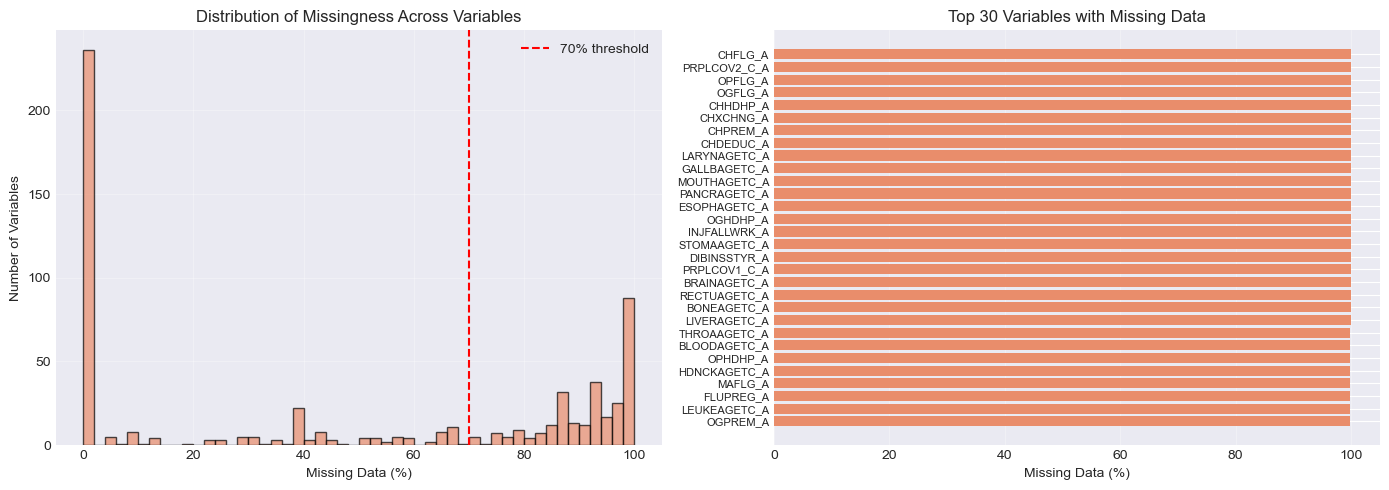

In [86]:
# First, let's understand missing data patterns BEFORE any imputation
# Overall missingness
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
print(f"\nTotal cells in dataset: {total_cells:,}")
print(f"Missing cells: {missing_cells:,}")
print(f"Overall missingness: {missing_cells/total_cells*100:.2f}%")

# Missingness by variable
missing_by_var = pd.DataFrame({
    'variable': df.columns,
    'missing_count': df.isnull().sum(),
    'missing_pct': (df.isnull().sum() / len(df) * 100)
}).sort_values('missing_pct', ascending=False)

# Show variables with any missing data
vars_with_missing = missing_by_var[missing_by_var['missing_count'] > 0]
print(f"\n{len(vars_with_missing)} variables have missing data")
print(f"\nTop 20 variables by missingness:")
print(vars_with_missing.head(20).to_string(index=False))

# Categorize variables by missingness level
high_missing = missing_by_var[missing_by_var['missing_pct'] > 70]
medium_missing = missing_by_var[(missing_by_var['missing_pct'] > 20) & (missing_by_var['missing_pct'] <= 70)]
low_missing = missing_by_var[(missing_by_var['missing_pct'] > 0) & (missing_by_var['missing_pct'] <= 20)]
complete = missing_by_var[missing_by_var['missing_pct'] == 0]

print(f"\nMissingness Distribution:")
print(f"  Complete (0% missing): {len(complete)} variables")
print(f"  Low (0-20% missing): {len(low_missing)} variables")
print(f"  Medium (20-70% missing): {len(medium_missing)} variables")
print(f"  High (>70% missing): {len(high_missing)} variables")

# Visualize missingness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of missingness percentages
axes[0].hist(missing_by_var['missing_pct'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=70, color='r', linestyle='--', label='70% threshold')
axes[0].set_xlabel('Missing Data (%)')
axes[0].set_ylabel('Number of Variables')
axes[0].set_title('Distribution of Missingness Across Variables')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Bar plot of top 30 most missing variables
top_30_missing = vars_with_missing.head(30)
axes[1].barh(range(len(top_30_missing)), top_30_missing['missing_pct'])
axes[1].set_yticks(range(len(top_30_missing)))
axes[1].set_yticklabels(top_30_missing['variable'], fontsize=8)
axes[1].set_xlabel('Missing Data (%)')
axes[1].set_title('Top 30 Variables with Missing Data')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [88]:
print("""
Three-tier approach based on missingness level:

1. HIGH MISSINGNESS (>70%): EXCLUDED
   - These variables contain too little information to be useful
   - Including them would introduce excessive uncertainty
   - {high_count} variables excluded
   
2. MEDIUM/LOW MISSINGNESS (0-70%): MEDIAN IMPUTATION
   - For numeric predictors used in modeling
   - Median chosen over mean because:
     * Robust to outliers
     * Appropriate for skewed distributions common in health data
   - Applied to {low_medium_count} variables
   
Rationale:

- For predictors, median imputation is simple, transparent, and works well with tree-based models
- More sophisticated methods (KNN, MICE) add complexity without guaranteed benefit for this application
""".format(
    high_count=len(high_missing),
    low_medium_count=len(low_missing) + len(medium_missing),
))


Three-tier approach based on missingness level:

1. HIGH MISSINGNESS (>70%): EXCLUDED
   - These variables contain too little information to be useful
   - Including them would introduce excessive uncertainty
   - 275 variables excluded
   
2. MEDIUM/LOW MISSINGNESS (0-70%): MEDIAN IMPUTATION
   - For numeric predictors used in modeling
   - Median chosen over mean because:
     * Robust to outliers
     * Appropriate for skewed distributions common in health data
   - Applied to 125 variables
   
Rationale:

- For predictors, median imputation is simple, transparent, and works well with tree-based models
- More sophisticated methods (KNN, MICE) add complexity without guaranteed benefit for this application



### 2. Missing Data Coding

The NHIS uses standardized numeric codes to represent different types of missing data:
- **7, 77, 777...** = Refused (respondent declined to answer)
- **8, 88, 888...** = Not Ascertained (data collection issue, incomplete interview)
- **9, 99, 999...** = Don't Know (respondent uncertain)

These coded values required conversion to `NaN` for proper statistical analysis. in doing so almost 50% of values were converted to Nan but also we are seeing in our analysis that most of these values are in column that will be unimportant and dropped shortly after this analysis 

In [91]:
# Count cells with missing codes BEFORE cleaning
missing_codes = [7, 8, 9, 77, 78, 79, 87, 88, 89, 97, 98, 99, 
                 777, 888, 999, 9997, 9998, 9999]

cells_with_codes = 0
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        cells_with_codes += df[col].isin(missing_codes).sum()

print(f"Cells containing missing codes (7,8,9,77,88,99, etc.): {cells_with_codes:,}")
print(f"Percentage of data: {cells_with_codes / (df.shape[0] * df.shape[1]) * 100:.2f}%")

# Create cleaned version
df_clean = df.copy()

# Replace missing codes with NaN for all numeric columns
print("\nReplacing missing codes with NaN...")

columns_cleaned = 0
total_replacements = 0

for col in df_clean.columns:
    # Only process numeric columns
    if df_clean[col].dtype in ['int64', 'float64']:
        # Count how many values will be replaced
        before_count = df_clean[col].isin(missing_codes).sum()
        
        if before_count > 0:
            # Replace all missing codes with NaN
            df_clean[col] = df_clean[col].replace(missing_codes, np.nan)
            columns_cleaned += 1
            total_replacements += before_count

print(f"\nCleaned {columns_cleaned} columns")
print(f"Total values converted to NaN: {total_replacements:,}")

# Verify cleaning worked
remaining_codes = 0
for col in df_clean.columns:
    if df_clean[col].dtype in ['int64', 'float64']:
        remaining_codes += df_clean[col].isin(missing_codes).sum()

print(f"Remaining missing codes after cleaning: {remaining_codes:,}")

if remaining_codes > 0:
    print("⚠ WARNING: Some missing codes remain. Investigating...")
    for col in df_clean.columns:
        if df_clean[col].dtype in ['int64', 'float64']:
            remaining = df_clean[col].isin(missing_codes).sum()
            if remaining > 0:
                print(f"  {col}: {remaining} values")
else:
    print("✓ All missing codes successfully converted to NaN")

# Summary statistics
print(f"\n{'='*80}")
print("MISSING DATA SUMMARY - AFTER CLEANING")
print(f"{'='*80}")

total_missing = df_clean.isnull().sum().sum()
total_cells = df_clean.shape[0] * df_clean.shape[1]

print(f"Total missing (NaN) values: {total_missing:,}")
print(f"Percentage of dataset: {total_missing / total_cells * 100:.2f}%")

# Variables with most missing data
missing_by_var = pd.DataFrame({
    'variable': df_clean.columns,
    'missing_count': df_clean.isnull().sum(),
    'missing_pct': df_clean.isnull().sum() / len(df_clean) * 100
}).sort_values('missing_pct', ascending=False)

print(f"\nTop 10 variables with most missing data:")
print(missing_by_var.head(10).to_string(index=False))

# Check specific important variables
important_vars = ['K6_SCORE', 'at_risk', 'LONELY_A', 'SUPPORT_A', 
                  'FGEFRQTRD_A', 'LSATIS4_A', 'PHSTAT_A', 'SLEEPHRS_A']

print(f"\n{'='*80}")
print("IMPORTANT VARIABLES - MISSING DATA CHECK")
print(f"{'='*80}")

for var in important_vars:
    if var in df_clean.columns:
        missing = df_clean[var].isnull().sum()
        pct = missing / len(df_clean) * 100
        print(f"{var:20s}: {missing:6,} missing ({pct:5.2f}%)")



Cells containing missing codes (7,8,9,77,88,99, etc.): 305,995
Percentage of data: 1.49%

Replacing missing codes with NaN...

Cleaned 569 columns
Total values converted to NaN: 305,995
Remaining missing codes after cleaning: 0
✓ All missing codes successfully converted to NaN

MISSING DATA SUMMARY - AFTER CLEANING
Total missing (NaN) values: 10,138,666
Percentage of dataset: 49.32%

Top 10 variables with most missing data:
    variable  missing_count  missing_pct
     CHFLG_A          32629   100.000000
    CHHDHP_A          32628    99.996935
     OGFLG_A          32628    99.996935
     OPFLG_A          32628    99.996935
PRPLCOV2_C_A          32628    99.996935
    CHPREM_A          32626    99.990806
   CHDEDUC_A          32626    99.990806
   CHXCHNG_A          32626    99.990806
LARYNAGETC_A          32626    99.990806
GALLBAGETC_A          32623    99.981611

IMPORTANT VARIABLES - MISSING DATA CHECK
LONELY_A            :  1,159 missing ( 3.55%)
SUPPORT_A           :  1,199 miss

### 3. K6 Psychological Distress Scale Construction

The primary outcome variable for this analysis is the K6 Psychological Distress Scale, which required construction from six component questions (Kessler et al., 2003). There was an original K6 related column but it was not a continous scale as expected in the implementation of this scale. Luckily the six fetures that make up this scale were also variables in the dataset and so I was able to sum on them and easily create a new column with contnious values ranging 0-24.  The NHIS reverse-codes K6 responses:

**Process:**
1. Identified six K6 component variables: SAD_A, NERVOUS_A, RESTLESS_A, HOPELESS_A, EFFORT_A, WORTHLESS_A
2. Recoded each component from NHIS 5-1 scale to standard 0-4 scale
3. Replaced missing data codes (7, 8, 9) with `NaN`
4. Calculated K6 total score by summing all six recoded components (range: 0-24)
5. **Required all six components to be non-missing** for valid K6 score calculation

**Missing Data Impact:**
- Total sample: 32,629 observations
- Valid K6 scores: 31,813 (97.5%)
- Missing K6 scores: 816 (2.5%)

Missing data was primarily due to:
- Refused responses (most common: ~80 per component)
- Not ascertained (~580 per component)
- Don't know (~30-60 per component)

#### 3. Clinical Threshold Variables Created

Based on established clinical cutpoints (Kessler et al., 2003; Prochaska et al., 2012):

- **K6_high_distress**: K6 ≥ 13 (serious psychological distress) - 3.6% prevalence
- **K6_any_distress**: K6 ≥ 5 (moderate-to-severe distress, treatment warranted) - 21.4% prevalence  
- **K6_moderate**: K6 8-12 (moderate distress) - 7.5% prevalence

#### 4. Statistics

All K6 scores fall within the expected range (0-24), with:
- Mean: 2.8
- Median: 2.0
- Range: 0-24 

No outliers were detected in the K6 score distribution. The right-skewed distribution (most people have low scores, few have high scores) is clinically expected and consistent with epidemiological research showing 3-6% of adults experience serious psychological distress.

### Anomalies 
In general, since I am not using all 630 variables such that I needed to check those distributions, so far nothing has jumped out as a problem variable and the target variable issue was resolved above.

## Analyzing for Target Variable

I have chosen to use the K6 score where K6 > 5 is a sign of some sort of distress and in my opnion is the minimum threshold that calls for preventative care intervention. 
On analyzing for the dataset I read that NHIS had coded there K6 score column to be only values 1,2, 8. What I am looking for is the scale from 0-24. But since we have the 6 raw variables that add up to create this score I can manually create a column in the dataset that calcualtes the score based on my 0-24 scale, allowing me to by medical industry standard classify a profile as in need of preventative care or not. I also had to recode he NHIS coding for the response to 0-4 scale as the other numbers represented no answers (nan) values.


In [94]:
# K6 components
k6_vars = ['SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A']

# STEP 1: Recode to 0-4 scale (reverse the NHIS coding)
k6_recode = {
    5: 0,  # None of the time
    4: 1,  # A little
    3: 2,  # Some
    2: 3,  # Most
    1: 4,  # All of the time
    7: np.nan,  # Refused
    8: np.nan,  # Not ascertained
    9: np.nan   # Don't know
}

# Apply recoding to each K6 component
for var in k6_vars:
    df_clean[f'{var}_recoded'] = df_clean[var].map(k6_recode)

# STEP 2: Calculate K6 score (sum of all 6 components)
# Only calculate if ALL six components are non-missing
recoded_vars = [f'{var}_recoded' for var in k6_vars]
df_clean['K6_SCORE'] = df_clean[recoded_vars].sum(axis=1, min_count=6)  # min_count=6 means all must be non-null

# STEP 3: Create binary target (K6 >= 5 = eligible for preventative care)
df_clean['at_risk'] = (df_clean['K6_SCORE'] >= 5).astype(float)

# STEP 4: Check the distribution
print("="*80)
print("K6 SCORE DISTRIBUTION")
print("="*80)
print(f"\nTotal observations: {len(df):,}")
print(f"Valid K6 scores: {df_clean['K6_SCORE'].notna().sum():,}")
print(f"Missing K6 scores: {df_clean['K6_SCORE'].isna().sum():,}")

print("\nK6 Score Statistics:")
print(df_clean['K6_SCORE'].describe())

print("\nK6 Score Value Counts:")
print(df_clean['K6_SCORE'].value_counts().sort_index())

print("\n" + "="*80)
print("HIGH DISTRESS (K6 >= 13)")
print("="*80)
high = (df_clean['K6_SCORE'] >= 13).sum()
total_valid = df_clean['K6_SCORE'].notna().sum()
print(f"High distress (K6 >= 13): {high:,} ({high/total_valid*100:.1f}%)")
print(f"Low distress (K6 < 13): {(df_clean['K6_SCORE'] < 13).sum():,} ({(df_clean['K6_SCORE'] < 13).sum()/total_valid*100:.1f}%)")

# Alternative thresholds for comparison
print("\n" + "="*80)
print("ALTERNATIVE THRESHOLDS")
print("="*80)
print(f"K6 >= 5 (any distress): {(df_clean['K6_SCORE'] >= 5).sum():,} ({(df_clean['K6_SCORE'] >= 5).sum()/total_valid*100:.1f}%)")
print(f"K6 >= 8 (moderate): {(df_clean['K6_SCORE'] >= 8).sum():,} ({(df_clean['K6_SCORE'] >= 8).sum()/total_valid*100:.1f}%)")

K6 SCORE DISTRIBUTION

Total observations: 32,629
Valid K6 scores: 31,813
Missing K6 scores: 816

K6 Score Statistics:
count    31813.000000
mean         2.720492
std          3.860018
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         24.000000
Name: K6_SCORE, dtype: float64

K6 Score Value Counts:
K6_SCORE
0.0     13031
1.0      3986
2.0      3802
3.0      2102
4.0      2075
5.0      1270
6.0      1255
7.0       762
8.0       697
9.0       539
10.0      454
11.0      333
12.0      369
13.0      257
14.0      228
15.0      156
16.0      131
17.0       78
18.0       99
19.0       49
20.0       36
21.0       28
22.0       22
23.0       17
24.0       37
Name: count, dtype: int64

HIGH DISTRESS (K6 >= 13)
High distress (K6 >= 13): 1,138 (3.6%)
Low distress (K6 < 13): 30,675 (96.4%)

ALTERNATIVE THRESHOLDS
K6 >= 5 (any distress): 6,817 (21.4%)
K6 >= 8 (moderate): 3,530 (11.1%)


In [95]:
df_clean['K6_SCORE'].median()

1.0

<Axes: >

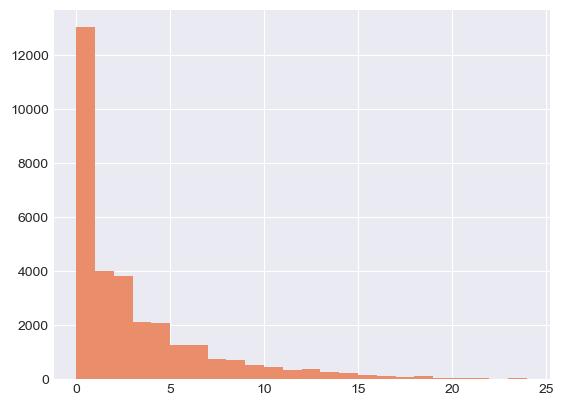

In [101]:
df_clean['K6_SCORE'].hist(bins=24)

## Conclusion on Data Quality 
Now that we have all these reports and I can see that majority variables are being droped due to being mostly nulls. I can already see a much better path to feature selection when we get to modelling. 
Finally I can take these analysis and build code to drop missing value columns and also impute data. I need to now make sure that K6 and any of its related columns do not get imputed as they are target variable values that should not be changed. 

**Below is the creation of the clean dataset that will be used for further EDA**

In [104]:
# Step 1: Keep only observations with valid K6 scores
valid_k6 = df_clean['K6_SCORE'].notna()
df_clean = df_clean[valid_k6]
print(f"\nStep 1 - Remove missing K6 scores:")
print(f"  Original: {len(df):,} observations")
print(f"  After filter: {len(df_clean):,} observations")
print(f"  Removed: {(~valid_k6).sum():,} observations")

# Step 2: Drop high-missingness variables (>70%)
cols_to_check = df_clean.select_dtypes(include=[np.number]).columns
missing_pct = df_clean[cols_to_check].isnull().sum() / len(df_clean)
high_missing_cols = missing_pct[missing_pct > 0.7].index.tolist()

print(f"\nStep 2 - Drop high-missingness variables (>70%):")
print(f"  Identified {len(high_missing_cols)} variables to drop")
print(f"  Examples: {high_missing_cols[:5]}")

df_clean = df_clean.drop(columns=high_missing_cols)

# Step 3: Identify predictor columns (exclude K6-related and admin variables)
exclude_from_imputation = [
    # K6-related
    'K6_SCORE', 'at_risk', 'high_distress', 'distress_threshold',
    'SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A',
    'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded', 
    'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded',
    'DEPFREQ_A', 'ANXFREQ_A', 'DEPLEVEL_A', 'ANXLEVEL_A', 'DEPMED_A', 'ANXMED_A', 'K6SPD_A',
    'ANXEV_A', 'DEPEV_A', 'MHRX_A', 'MHTHRPY_A', 'MHTHND_A', 'MHTHDLY_A',
    'cluster',
    # Admin
    'HHX', 'WTFA_A', 'PPSU', 'PSTRAT', 'RECTYPE', 'SRVY_YR', 'IMPNUM_A', 
    'HHSTAT_A', 'ASTATNEW',
]

# Get numeric columns that should be imputed
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
cols_to_impute = [col for col in numeric_cols if col not in exclude_from_imputation]

print(f"\nStep 3 - Identify columns for imputation:")
print(f"  Total numeric columns: {len(numeric_cols)}")
print(f"  Excluded from imputation: {len([c for c in exclude_from_imputation if c in df_clean.columns])}")
print(f"  To be imputed: {len(cols_to_impute)}")

# Step 4: Apply median imputation
print(f"\nStep 4 - Apply median imputation:")
missing_before = df_clean[cols_to_impute].isnull().sum().sum()
print(f"  Missing values before: {missing_before:,}")

imputer = SimpleImputer(strategy='median')
df_clean[cols_to_impute] = imputer.fit_transform(df_clean[cols_to_impute])

missing_after = df_clean[cols_to_impute].isnull().sum().sum()
print(f"  Missing values after: {missing_after:,}")
print(f"  Successfully imputed: {missing_before - missing_after:,} values")

# Step 5: Summary
print(f"\n{'='*80}")
print("CLEANED DATASET SUMMARY")
print(f"{'='*80}")
print(f"Observations: {len(df_clean):,}")
print(f"Features: {df_clean.shape[1]}")
print(f"Total missing values: {df_clean.isnull().sum().sum():,}")
print(f"At-risk prevalence (K6≥5): {df_clean['at_risk'].mean()*100:.1f}%")

# Verify - check a few imputed variables
print(f"\nSample of imputed variables (should have 0 missing):")
sample_imputed = cols_to_impute[:5]
for col in sample_imputed:
    missing = df_clean[col].isnull().sum()
    print(f"  {col}: {missing} missing")


Step 1 - Remove missing K6 scores:
  Original: 32,629 observations
  After filter: 31,813 observations
  Removed: 816 observations

Step 2 - Drop high-missingness variables (>70%):
  Identified 277 variables to drop
  Examples: ['WLKTRANTC_A', 'SCHDYMSSTC_A', 'REPWRKDYTC_A', 'YRSINUS_A', 'PRTNREDUCP_A']

Step 3 - Identify columns for imputation:
  Total numeric columns: 359
  Excluded from imputation: 36
  To be imputed: 324

Step 4 - Apply median imputation:
  Missing values before: 1,620,163
  Missing values after: 0
  Successfully imputed: 1,620,163 values

CLEANED DATASET SUMMARY
Observations: 31,813
Features: 361
Total missing values: 54,423
At-risk prevalence (K6≥5): 21.4%

Sample of imputed variables (should have 0 missing):
  RATCAT_A: 0 missing
  INCTCFLG_A: 0 missing
  IMPINCFLG_A: 0 missing
  WLKLEISTC_A: 0 missing
  HISPALLP_A: 0 missing


Great now I have a clean dataset - I want to now start seeing stats and what kind of information this dataset holds. I can now break down some basic descirptive stats as viz before I move on to the  more complex clustering and correlation analysis **(as reccomended by prof in feedback)**

### Feature Decisions 
I had to make some assumptions and decisions based on domain knowledge, research and the dataset structure and what the guide pdfs indicated as general categories. Based on these categories I will do EDA and visualizations to show what I found during EDA. Here are the braod catgories:

1. Mental Health Indicators
2. Behavioural Indicators
3. Chronic Conditions
4. K6 Components*

* The K6 measurement is a way to detemine mental illness severit and CDC itself holds studies about the validity of the system and description. What we need to know is that it basis the scale on 6 factors that I will elicit below. I want to use these in the algorithm as the target variables. -- ( this was updated later in the notebook when I learnt that K6 was a column but not in useable form)
From the CDC website:

_A measure increasingly used in epidemiological studies is the K6 non‐specific distress scale, a six‐item, psychological screening instrument, developed by Kessler et al. (2002), which takes < 2 minutes to complete and screens at the population level for individuals with possible severe mental illness. Developed for use in the annual US National Health Interview Survey and National Household Survey on Drug Abuse, the K6 has yielded national‐ and state‐level estimates of serious mental illness and informed the funding of block grants for community mental health services (Centers for Disease Control, 2010; Grant et al., 2010; Kessler et al., 2002; Kessler et al., 2003)_

### Analyzing with Charts
So these viz are more of a overview. We will get more rich information when I do correlation and cluster analysis on these categories of features. This is going to be a theme for the next few categories of Visualizations. The charts will very clearly show top contenders of demographics and answer choices. I intend to use charts that work best for descriptive statistics such as histograms, violin plots, scatter plots and bar plot like cohorts.


### Demogrpahics Overview

In [110]:
demographic_vars = {
    'AGEP_A': 'Age',
    'SEX_A': 'Sex',
    'HISPALLP_A': 'Race/Ethnicity',
    'EDUCP_A': 'Education',
    'MARITAL_A': 'Marital Status',
    'POVRATTC_A': 'Poverty Ratio'
}

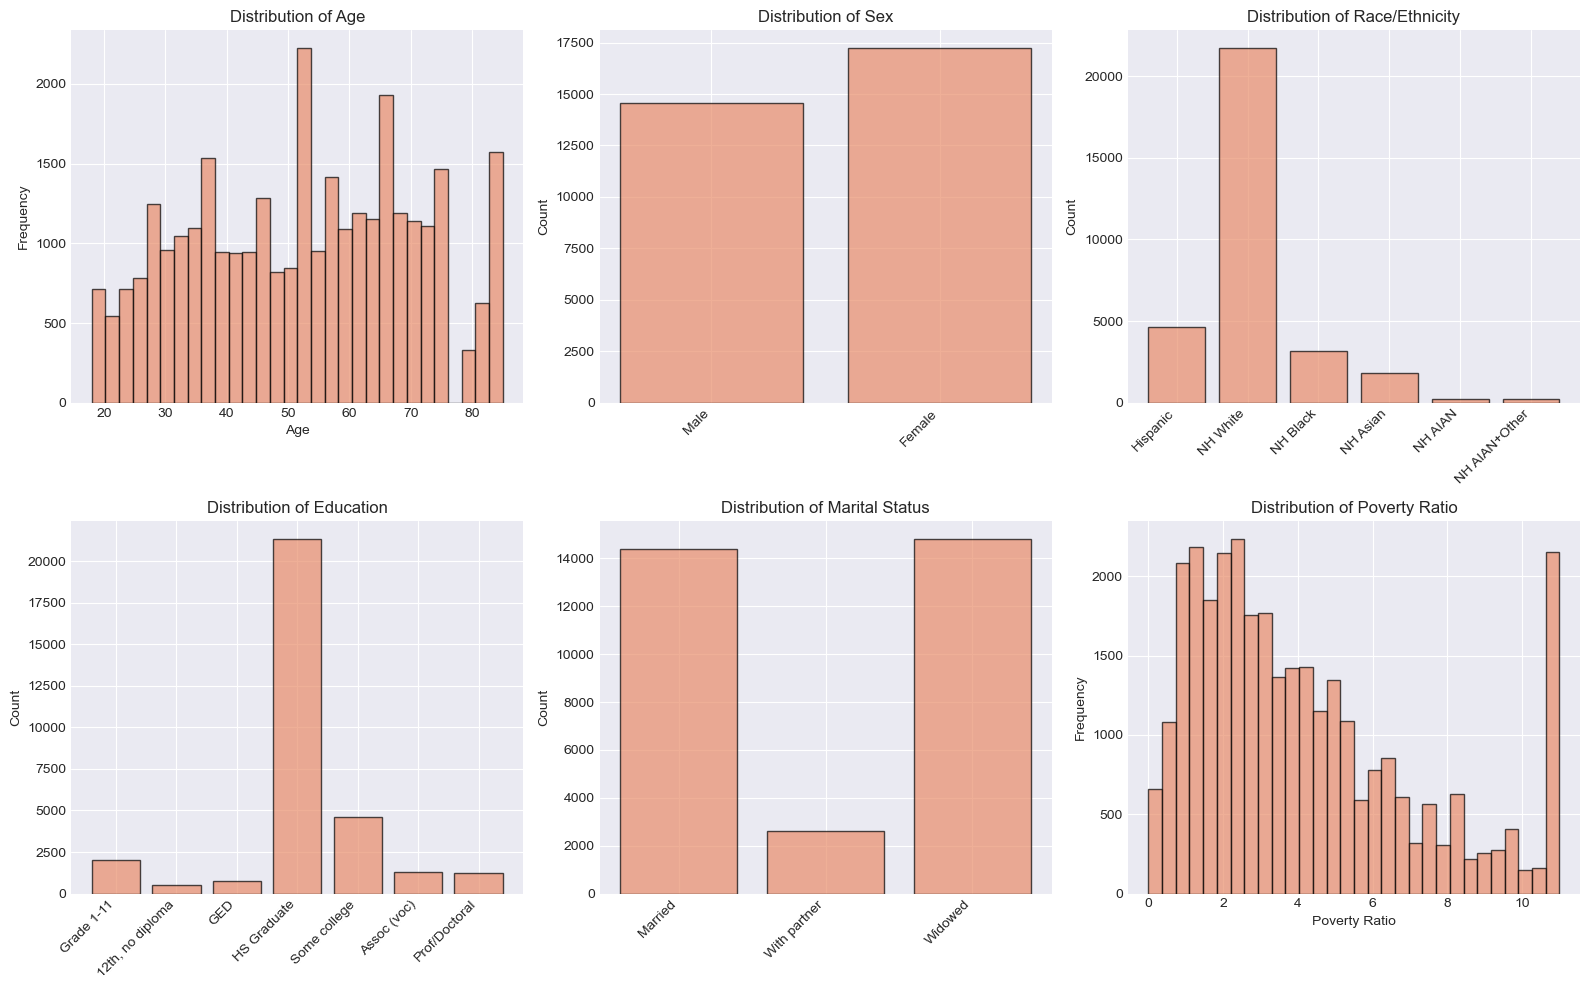

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Updated plotting code with proper labels
for idx, (var, label) in enumerate(demographic_vars.items()):
    ax = axes[idx]
    
    if var in ['AGEP_A', 'POVRATTC_A']:  # Continuous
        data = df_clean[var].dropna() # Just to be sure you know
        ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
        ax.set_xlabel(label)
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {label}')
    else:  # Categorical - USE LABELS
        data = df_clean[var].value_counts().sort_index()
        
        # Get labels if available
        if var in value_labels:
            labels = [value_labels[var].get(x, str(x)) for x in data.index]
        else:
            labels = [str(x) for x in data.index]
        
        ax.bar(range(len(data)), data.values, edgecolor='black', alpha=0.7)
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of {label}')
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Mental Health Overview

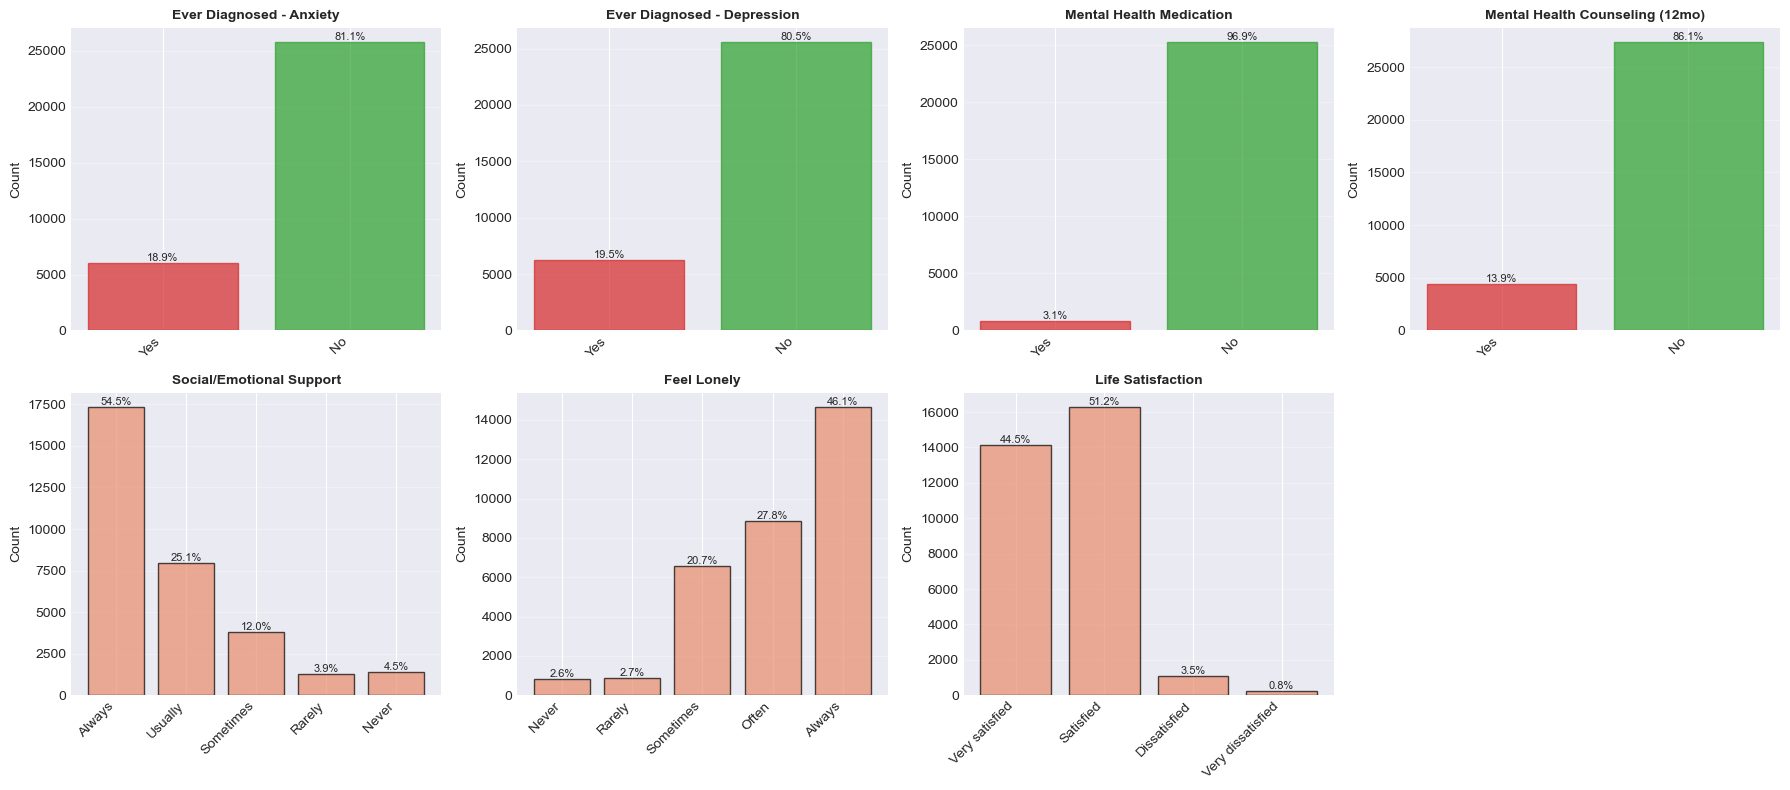

In [115]:
# Mental HEalth Indicators

mental_health_vars = {
    'ANXEV_A': 'Ever Diagnosed - Anxiety',
    'DEPEV_A': 'Ever Diagnosed - Depression',
    'MHRX_A': 'Mental Health Medication',
    'MHTHRPY_A': 'Mental Health Counseling (12mo)',
    'SUPPORT_A': 'Social/Emotional Support',
    'LONELY_A': 'Feel Lonely',
    'LSATIS4_A': 'Life Satisfaction'
}

# Value labels for mental health variables
mental_health_labels = {
    'ANXEV_A': {1: 'Yes', 2: 'No'},
    'DEPEV_A': {1: 'Yes', 2: 'No'},
    'MHRX_A': {1: 'Yes', 2: 'No'},
    'MHTHRPY_A': {1: 'Yes', 2: 'No'},
    'SUPPORT_A': {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'},
    'LONELY_A': {1: 'Never', 2: 'Rarely', 3: 'Sometimes', 4: 'Often', 5: 'Always'},
    'LSATIS4_A': {1: 'Very satisfied', 2: 'Satisfied', 3: 'Dissatisfied', 4: 'Very dissatisfied'}
}
    

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for idx, (var, label) in enumerate(mental_health_vars.items()):
    ax = axes[idx]
    
    # Get value counts and sort by index
    data = df_clean[var].value_counts().sort_index()
    
    # Filter out missing codes (7, 8, 9) for cleaner visualization
    valid_codes = [x for x in data.index if x not in [7, 8, 9]]
    data_clean = data[data.index.isin(valid_codes)]
    
    # Get labels
    if var in mental_health_labels:
        labels = [mental_health_labels[var].get(x, str(x)) for x in data_clean.index]
    else:
        labels = [str(x) for x in data_clean.index]
    
    # Create bar plot
    bars = ax.bar(range(len(data_clean)), data_clean.values, edgecolor='black', alpha=0.7)
    
    # Color code Yes/No questions
    if var in ['ANXEV_A', 'DEPEV_A', 'MHRX_A', 'MHTHRPY_A']:
        colors = ['#d62728', '#2ca02c']  # Red for Yes, Green for No
        for i, bar in enumerate(bars):
            if i < len(colors):
                bar.set_color(colors[i])
    
    ax.set_ylabel('Count')
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.set_xticks(range(len(data_clean)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    total = data_clean.sum()
    for i, (bar, value) in enumerate(zip(bars, data_clean.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value/total*100:.1f}%',
                ha='center', va='bottom', fontsize=8)

# Hide the last empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [116]:
# Prevalence summary
print("\nMental Health Summary Statistics:")
print("-" * 80)

# Diagnoses
anx_yes = (df_clean['ANXEV_A'] == 1).sum()
anx_total = df_clean['ANXEV_A'].notna().sum()
dep_yes = (df_clean['DEPEV_A'] == 1).sum()
dep_total = df_clean['DEPEV_A'].notna().sum()
either = ((df_clean['ANXEV_A'] == 1) | (df_clean['DEPEV_A'] == 1)).sum()
both = ((df_clean['ANXEV_A'] == 1) & (df_clean['DEPEV_A'] == 1)).sum()

print(f"Anxiety Diagnosis:     {anx_yes:,} / {anx_total:,} ({anx_yes/anx_total*100:.1f}%)")
print(f"Depression Diagnosis:  {dep_yes:,} / {dep_total:,} ({dep_yes/dep_total*100:.1f}%)")
print(f"Either Diagnosis:      {either:,} ({either/min(anx_total, dep_total)*100:.1f}%)")
print(f"Both Diagnoses:        {both:,} ({both/min(anx_total, dep_total)*100:.1f}%)")

# Treatment
mhrx_yes = (df_clean['MHRX_A'] == 1).sum()
mhrx_total = df_clean['MHRX_A'].notna().sum()
therapy_yes = (df_clean['MHTHRPY_A'] == 1).sum()
therapy_total = df_clean['MHTHRPY_A'].notna().sum()

print(f"\nMental Health Medication: {mhrx_yes:,} / {mhrx_total:,} ({mhrx_yes/mhrx_total*100:.1f}%)")
print(f"Counseling (12 months):   {therapy_yes:,} / {therapy_total:,} ({therapy_yes/therapy_total*100:.1f}%)")

# Social factors
support_always = (df_clean['SUPPORT_A'] == 1).sum()
support_total = df_clean['SUPPORT_A'].notna().sum()
lonely_often = ((df_clean['LONELY_A'] == 4) | (df['LONELY_A'] == 5)).sum()
lonely_total = df_clean['LONELY_A'].notna().sum()
satisfied = ((df_clean['LSATIS4_A'] == 1) | (df['LSATIS4_A'] == 2)).sum()
satisfied_total = df_clean['LSATIS4_A'].notna().sum()

print(f"\nAlways have social support:  {support_always:,} / {support_total:,} ({support_always/support_total*100:.1f}%)")
print(f"Often/Always lonely:         {lonely_often:,} / {lonely_total:,} ({lonely_often/lonely_total*100:.1f}%)")
print(f"Satisfied with life:         {satisfied:,} / {satisfied_total:,} ({satisfied/satisfied_total*100:.1f}%)")


Mental Health Summary Statistics:
--------------------------------------------------------------------------------
Anxiety Diagnosis:     6,000 / 31,783 (18.9%)
Depression Diagnosis:  6,211 / 31,785 (19.5%)
Either Diagnosis:      8,122 (25.6%)
Both Diagnoses:        4,089 (12.9%)

Mental Health Medication: 820 / 26,079 (3.1%)
Counseling (12 months):   4,434 / 31,792 (13.9%)

Always have social support:  17,346 / 31,813 (54.5%)
Often/Always lonely:         23,511 / 31,813 (73.9%)
Satisfied with life:         30,384 / 31,813 (95.5%)


Here the thing to note is that for preventative actions even ~20% is a significant number that can be addressed to reduce future overall rates of depression / anxiety in adults. It does not only impact the absolute but trickles down into better future stats 

## Behavioural Indicators 

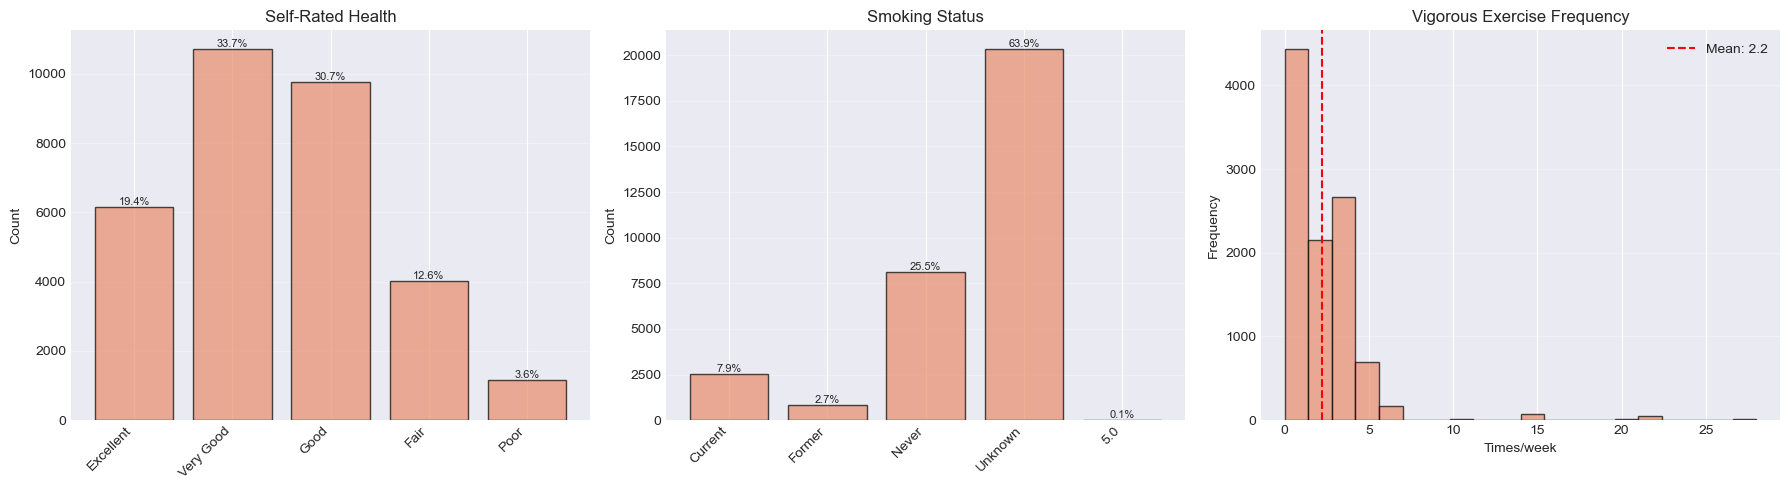

In [121]:
behavior_vars = {
    'PHSTAT_A': 'Self-Rated Health',
    'SMKCIGST_A': 'Smoking Status',
    'VIGFREQW_A': 'Vigorous Exercise Frequency',
    'SLEEPHRS_A': 'Hours of Sleep'
}

# Filter to variables that exist
behavior_vars = {k: v for k, v in behavior_vars.items() if k in df_clean.columns}

if behavior_vars:
    n_vars = len(behavior_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()

    for idx, (var, label) in enumerate(behavior_vars.items()):
        ax = axes[idx]
        
        if var in ['SLEEPHRS_A', 'VIGFREQW_A']:  # Continuous
            data = df_clean[var].dropna()
            # Filter reasonable values
            if var == 'SLEEPHRS_A':
                data = data[(data >= 1) & (data <= 18)]
            else:
                data = data[(data >= 0) & (data <= 30)]
            ax.hist(data, bins=20, edgecolor='black', alpha=0.7)
            ax.set_xlabel('Hours' if var == 'SLEEPHRS_A' else 'Times/week')
            ax.set_ylabel('Frequency')
            ax.set_title(label)
            if len(data) > 0:
                ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.1f}')
                ax.legend()
        else:  # Categorical
            data = df_clean[var].value_counts().sort_index()
            valid_codes = [x for x in data.index if x not in [7, 8, 9, 97, 98, 99]]
            data_clean = data[data.index.isin(valid_codes)]
            
            if var in value_labels:
                labels = [value_labels[var].get(x, str(x)) for x in data_clean.index]
            else:
                labels = [str(x) for x in data_clean.index]
            
            bars = ax.bar(range(len(data_clean)), data_clean.values, edgecolor='black', alpha=0.7)
            ax.set_ylabel('Count')
            ax.set_title(label)
            ax.set_xticks(range(len(data_clean)))
            ax.set_xticklabels(labels, rotation=45, ha='right')
            
            total = data_clean.sum()
            for i, (bar, value) in enumerate(zip(bars, data_clean.values)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{value/total*100:.1f}%',
                        ha='center', va='bottom', fontsize=8)
        
        ax.grid(alpha=0.3, axis='y')

    # Hide empty subplots
    for idx in range(len(behavior_vars), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

I want to note the response bias here where I do think when asked how well you are doing yo almost always will overestimate as comfort to your own psyche

### Chronic Conditions 

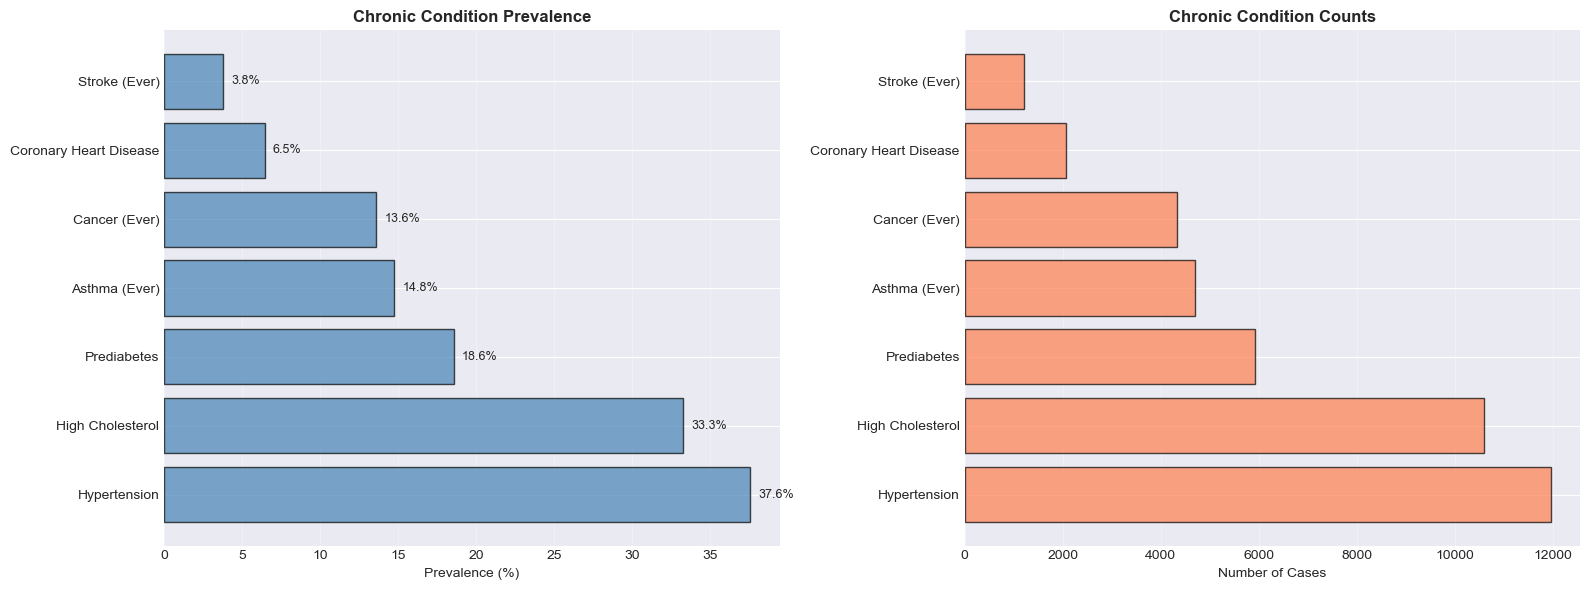


Chronic Condition Summary:
             Condition   Yes  Total  Prevalence (%)
          Hypertension 11952  31813       37.569547
      High Cholesterol 10590  31813       33.288278
           Prediabetes  5912  31813       18.583598
         Asthma (Ever)  4696  31813       14.761261
         Cancer (Ever)  4329  31813       13.607645
Coronary Heart Disease  2058  31813        6.469054
         Stroke (Ever)  1205  31813        3.787760


In [125]:
chronic_vars = {
    'PREDIB_A': 'Prediabetes',
    'DIABETICEV_A': 'Diabetes',
    'CHLEV_A': 'High Cholesterol',
    'HYPEV_A': 'Hypertension',
    'CHDEV_A': 'Coronary Heart Disease',
    'ASEV_A': 'Asthma (Ever)',
    'CANEV_A': 'Cancer (Ever)',
    'STREV_A': 'Stroke (Ever)'
}

# Filter to variables that exist
chronic_vars = {k: v for k, v in chronic_vars.items() if k in df_clean.columns}

if chronic_vars:
    # Calculate prevalence
    prev_data = []
    for var, label in chronic_vars.items():
        yes_count = (df_clean[var] == 1).sum()
        total = df_clean[var].notna().sum()
        prev_pct = (yes_count / total * 100) if total > 0 else 0
        prev_data.append({
            'Condition': label,
            'Yes': yes_count,
            'Total': total,
            'Prevalence (%)': prev_pct
        })

    prev_df = pd.DataFrame(prev_data).sort_values('Prevalence (%)', ascending=False)

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart of prevalence
    axes[0].barh(prev_df['Condition'], prev_df['Prevalence (%)'], 
                 edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_xlabel('Prevalence (%)')
    axes[0].set_title('Chronic Condition Prevalence', fontweight='bold')
    axes[0].grid(alpha=0.3, axis='x')

    # Add percentage labels
    for i, (idx, row) in enumerate(prev_df.iterrows()):
        axes[0].text(row['Prevalence (%)'] + 0.5, i, f"{row['Prevalence (%)']:.1f}%",
                     va='center', fontsize=9)

    # Counts
    axes[1].barh(prev_df['Condition'], prev_df['Yes'], 
                 edgecolor='black', alpha=0.7, color='coral')
    axes[1].set_xlabel('Number of Cases')
    axes[1].set_title('Chronic Condition Counts', fontweight='bold')
    axes[1].grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    print("\nChronic Condition Summary:")
    print(prev_df.to_string(index=False))

An overview of some very obvious correlations where a high number of people questioned about their heart health actually do have heart issues

# Data Characteristics 
Now comes the part of finding deeper than descriptive statistics like patterns in the data. I wanted to, on the reccomendation of the professor - carry out cluster analysis. But at the same time since my domain knowledge was weak I did not want to disregard any features since I am not sure of their importance in realtion to my problem statement yet. 
To approach the problem of picking non redundant and informative features I used my work experience and statistical (DS502) modelling knowledge to come up with the idea of modelling a random forest like model only to infer the feature importance on the same target variable of k6 > 5 and then further do clustering but I think that is also getitng ahead as my model will be basically the same -ish. Okay so only correlation and clsutering on all clean features for now 


Target Variable: at_risk (K6 >= 5)
----------------------------------------
               Class  Count  Percentage
Not at risk (K6 < 5)  24996   78.571653
   At risk (K6 >= 5)   6817   21.428347

Class imbalance ratio: 3.67:1


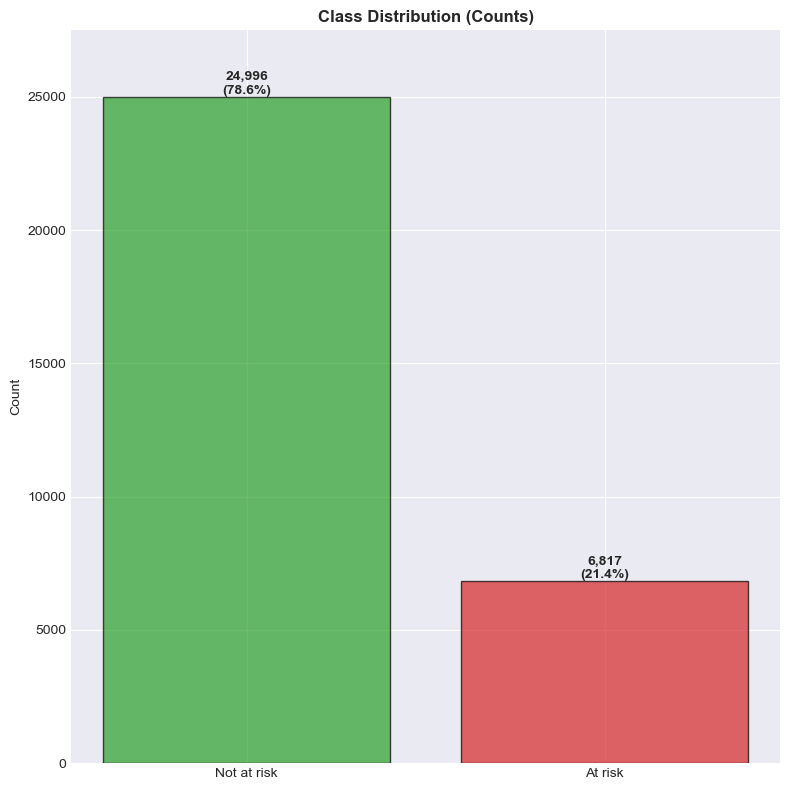

In [129]:
# Addressing Professor Feedback: Clustering, Correlations, Class Balance

# Check balance for main target variable
print("\nTarget Variable: at_risk (K6 >= 5)")
print("-" * 40)
class_counts = df_clean['at_risk'].value_counts()
class_props = df_clean['at_risk'].value_counts(normalize=True) * 100

balance_df = pd.DataFrame({
    'Class': ['Not at risk (K6 < 5)', 'At risk (K6 >= 5)'],
    'Count': [class_counts[0], class_counts[1]],
    'Percentage': [class_props[0], class_props[1]]
})

print(balance_df.to_string(index=False))
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Visualize class balance
fig, ax = plt.subplots(figsize=(8, 8))

# Count plot
ax.bar(['Not at risk', 'At risk'], class_counts.values, 
            color=['#2ca02c', '#d62728'], edgecolor='black', alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('Class Distribution (Counts)', fontweight='bold')
ax.set_ylim(0, max(class_counts.values) * 1.1)
for i, (count, pct) in enumerate(zip(class_counts.values, class_props.values)):
    ax.text(i, count, f'{count:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

I knew this but here is a colorful chart for it. This is fine for target variable I will stratergize the algorithm I choose accordingly.

Lets look at some hist, and plots like before but vs K6 scoring to see another pespective of correlations 

But actually before that based on **feedback(ADDED LATER)** lets also take a glance at the descriptive statistics and get another perspective on the imblanace and its effects.

In [134]:
# Create descriptive statistics table comparing at-risk vs not-at-risk groups
import pandas as pd
import numpy as np

# Define ALL K6-related columns to exclude (prevent leakage)
K6_ALL_VARS = [
    'SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A',  # Original K6 items
    'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded',  # Recoded versions
    'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded',
    'K6_SCORE', 'at_risk', 'age_group'  # Derived variables
]

# Key predictors to analyze (excluding ALL K6 items)
key_predictors = [
    'AGEP_A',      # Age
    'SEX_A',       # Sex
    'EDUC_A',      # Education
    'EMPSTAT_A',   # Employment status
    'POVRATTC_A',  # Poverty ratio
    'SMKSTAT_A',   # Smoking status
    'ANXFREQ_A',   # Anxiety frequency (separate from K6)
    'DEPFREQ_A',   # Depression frequency (separate from K6)
    'PAYBLL12M_A', # Problems paying bills
    'PDMED12M_A',  # Delayed medical care
]

# Remove any K6 items if accidentally included
key_predictors = [col for col in key_predictors if col not in K6_ALL_VARS]

# Calculate descriptive statistics by risk group
def create_risk_comparison_table(df_clean, predictors, var_dict):
    """
    Create a comparison table showing key statistics for at-risk vs not-at-risk groups
    """
    results = []
    
    for var in predictors:
        if var in df_clean.columns:
            readable_name = get_readable_name(var, var_dict)
            
            # For numerical variables
            if df_clean[var].dtype in ['float64', 'int64']:
                not_risk = df_clean[df_clean['at_risk'] == 0][var].dropna()
                at_risk = df_clean[df_clean['at_risk'] == 1][var].dropna()
                
                if len(not_risk) > 0 and len(at_risk) > 0:
                    results.append({
                        'Variable': readable_name,
                        'Code': var,
                        'Not At-Risk Mean': f"{not_risk.mean():.2f}",
                        'At-Risk Mean': f"{at_risk.mean():.2f}",
                        'Not At-Risk SD': f"{not_risk.std():.2f}",
                        'At-Risk SD': f"{at_risk.std():.2f}",
                        'Effect Direction': '↑ Higher risk' if at_risk.mean() > not_risk.mean() else '↓ Lower risk'
                    })
            
            # For categorical variables - show most common category
            else:
                not_risk_counts = df_clean[df_clean['at_risk'] == 0][var].value_counts()
                at_risk_counts = df_clean[df_clean['at_risk'] == 1][var].value_counts()
                
                if len(not_risk_counts) > 0 and len(at_risk_counts) > 0:
                    not_risk_mode = not_risk_counts.index[0]
                    at_risk_mode = at_risk_counts.index[0]
                    
                    results.append({
                        'Variable': readable_name,
                        'Code': var,
                        'Not At-Risk Mode': not_risk_mode,
                        'At-Risk Mode': at_risk_mode,
                        'Not At-Risk %': f"{not_risk_counts.iloc[0] / not_risk_counts.sum() * 100:.1f}%",
                        'At-Risk %': f"{at_risk_counts.iloc[0] / at_risk_counts.sum() * 100:.1f}%"
                    })
    
    return pd.DataFrame(results)

# Create and display the table
risk_comparison = create_risk_comparison_table(df_clean, key_predictors, var_dict)
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS: AT-RISK vs NOT AT-RISK COMPARISON")
print("="*80)
print("(Using human-readable variable names from NHIS codebook)")
print("="*80)
display(risk_comparison)

# Calculate class imbalance ratio
n_not_risk = (df_clean['at_risk'] == 0).sum()
n_at_risk = (df_clean['at_risk'] == 1).sum()
imbalance_ratio = n_not_risk / n_at_risk

print(f"\nClass Distribution:")
print(f"  Not At-Risk (K6 < 5): {n_not_risk:,} ({n_not_risk/len(df_clean)*100:.1f}%)")
print(f"  At-Risk (K6 ≥ 5): {n_at_risk:,} ({n_at_risk/len(df_clean)*100:.1f}%)")
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")


DESCRIPTIVE STATISTICS: AT-RISK vs NOT AT-RISK COMPARISON
(Using human-readable variable names from NHIS codebook)


,Variable,Code,Not At-Risk Mean,At-Risk Mean,Not At-Risk SD,At-Risk SD,Effect Direction
0,Age (top-coded at 85+),AGEP_A,53.76,47.23,17.70,17.76,↓ Lower risk
1,Sex,SEX_A,1.52,1.61,0.50,0.49,↑ Higher risk
2,Poverty ratio,POVRATTC_A,4.34,3.37,3.00,2.71,↓ Lower risk
3,Frequency of anxiety,ANXFREQ_A,3.87,2.06,1.16,1.19,↓ Lower risk
4,Frequency of depression,DEPFREQ_A,4.54,2.99,0.73,1.30,↓ Lower risk
5,Problems paying medical bills,PAYBLL12M_A,1.93,1.80,0.26,0.40,↓ Lower risk



Class Distribution:
  Not At-Risk (K6 < 5): 24,996 (78.6%)
  At-Risk (K6 ≥ 5): 6,817 (21.4%)
  Imbalance Ratio: 3.67:1


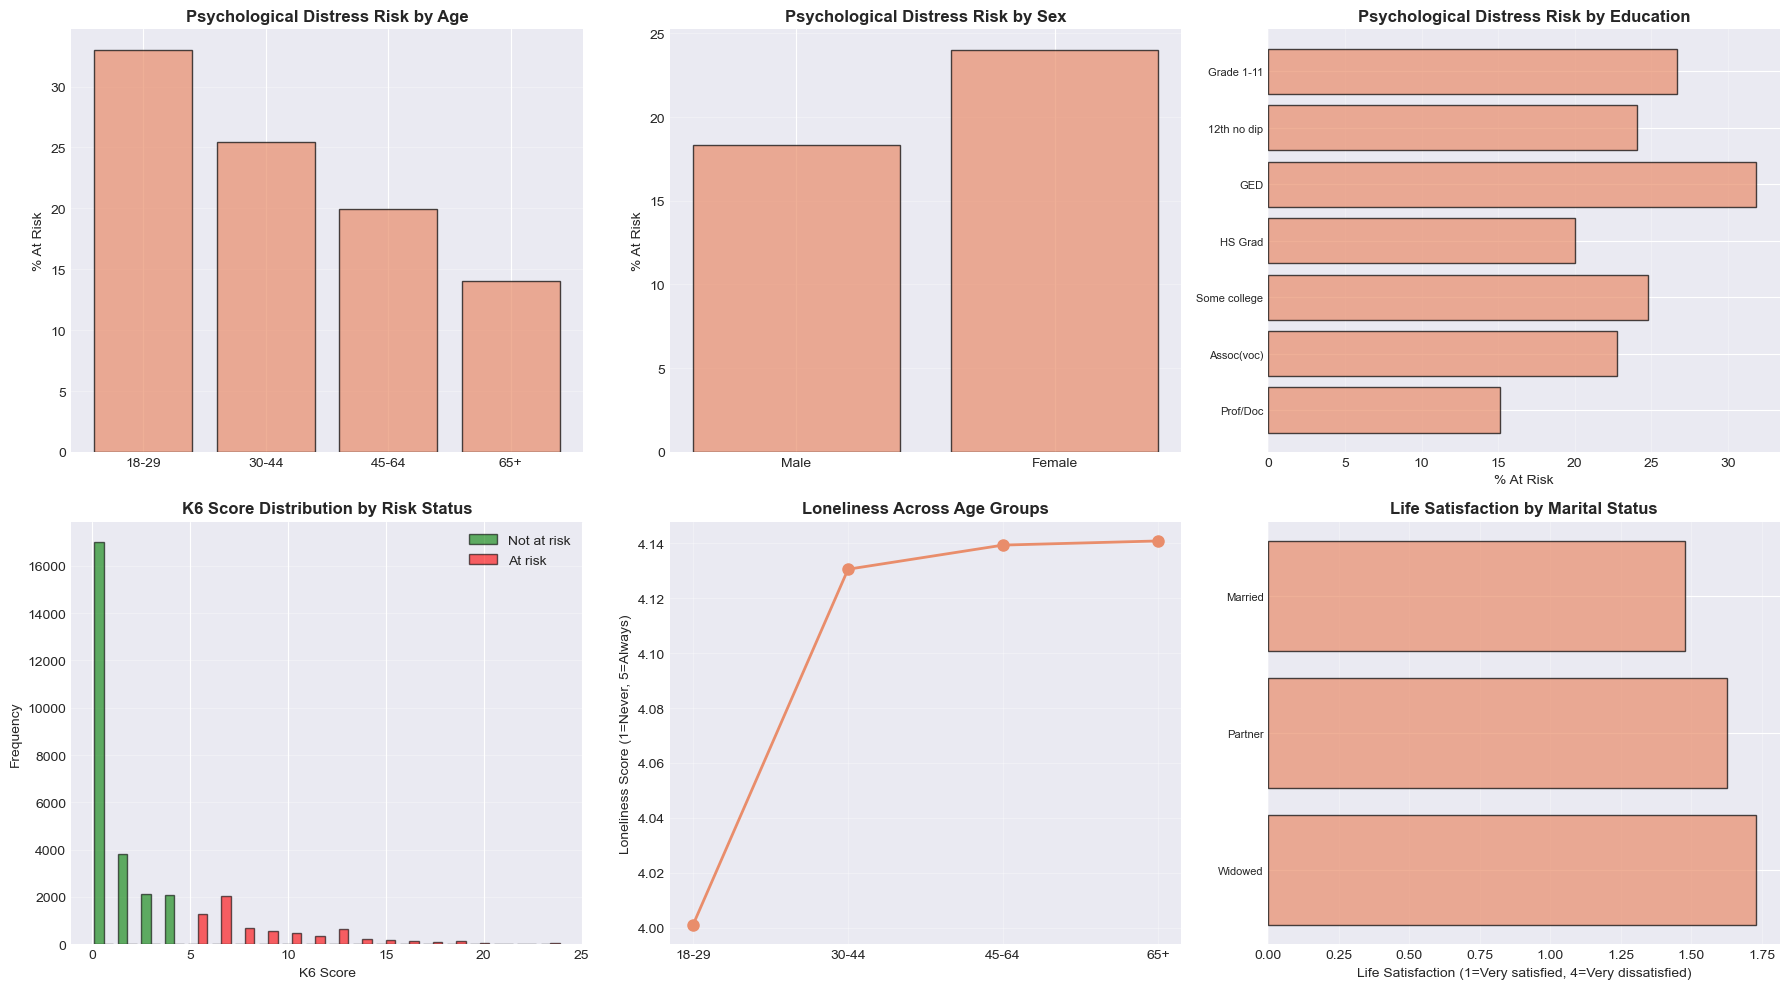


Statistical Tests for Demographic Differences:
--------------------------------------------------------------------------------
Sex vs At-Risk Status:
  Chi-square = 150.95, p-value = 0.0000
  Significant difference

Age Group vs K6 Score:
  F-statistic = 276.45, p-value = 0.0000
  Significant difference


In [137]:
# Mental HEalth vs K6
# Age grouping for better visualization
df_clean['age_group'] = pd.cut(df_clean['AGEP_A'], 
                                bins=[18, 30, 45, 65, 100],
                                labels=['18-29', '30-44', '45-64', '65+'])

# Visualize key demographic patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 1. At-risk prevalence by age
age_risk = df_clean.groupby('age_group')['at_risk'].mean() * 100
axes[0].bar(range(len(age_risk)), age_risk.values, edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(age_risk)))
axes[0].set_xticklabels(age_risk.index)
axes[0].set_ylabel('% At Risk')
axes[0].set_title('Psychological Distress Risk by Age', fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# 2. At-risk prevalence by sex
sex_labels = {1: 'Male', 2: 'Female'}
sex_risk = df_clean.groupby('SEX_A')['at_risk'].mean() * 100
# Filter out missing codes
sex_risk = sex_risk[sex_risk.index.isin([1, 2])]
sex_names = [sex_labels.get(x, str(x)) for x in sex_risk.index]
axes[1].bar(range(len(sex_risk)), sex_risk.values, edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(sex_risk)))
axes[1].set_xticklabels(sex_names)
axes[1].set_ylabel('% At Risk')
axes[1].set_title('Psychological Distress Risk by Sex', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

# 3. At-risk by education - FIXED
edu_risk = df_clean.groupby('EDUCP_A')['at_risk'].mean() * 100
# Filter to valid education codes only (1-10)
valid_edu_codes = [i for i in range(1, 11) if i in edu_risk.index]
edu_risk = edu_risk[valid_edu_codes]

edu_labels = {
    1: 'Grade 1-11',
    2: '12th no dip',
    3: 'GED',
    4: 'HS Grad',
    5: 'Some college',
    6: 'Assoc(voc)',
    7: 'Assoc(acad)',
    8: "Bachelor's",
    9: "Master's",
    10: 'Prof/Doc'
}

edu_label_list = [edu_labels[i] for i in valid_edu_codes]

axes[2].barh(range(len(edu_risk)), edu_risk.values, edgecolor='black', alpha=0.7)
axes[2].set_yticks(range(len(edu_risk)))
axes[2].set_yticklabels(edu_label_list, fontsize=8)
axes[2].set_xlabel('% At Risk')
axes[2].set_title('Psychological Distress Risk by Education', fontweight='bold')
axes[2].grid(alpha=0.3, axis='x')
axes[2].invert_yaxis()

# 4. K6 score distribution by at-risk status
at_risk_k6 = df_clean[df_clean['at_risk'] == 1]['K6_SCORE']
not_risk_k6 = df_clean[df_clean['at_risk'] == 0]['K6_SCORE']
axes[3].hist([not_risk_k6, at_risk_k6], bins=20, label=['Not at risk', 'At risk'],
            color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[3].set_xlabel('K6 Score')
axes[3].set_ylabel('Frequency')
axes[3].set_title('K6 Score Distribution by Risk Status', fontweight='bold')
axes[3].legend()
axes[3].grid(alpha=0.3, axis='y')

# 5. Loneliness by age group
lonely_age = df_clean.groupby('age_group')['LONELY_A'].mean()
axes[4].plot(range(len(lonely_age)), lonely_age.values, 
            marker='o', linewidth=2, markersize=8)
axes[4].set_xticks(range(len(lonely_age)))
axes[4].set_xticklabels(lonely_age.index)
axes[4].set_ylabel('Loneliness Score (1=Never, 5=Always)')
axes[4].set_title('Loneliness Across Age Groups', fontweight='bold')
axes[4].grid(alpha=0.3)

# 6. Life satisfaction by marital status
marital_labels = {1: 'Married', 2: 'Partner', 3: 'Widowed', 
                 4: 'Divorced', 5: 'Separated', 6: 'Never married'}
marital_satis = df_clean.groupby('MARITAL_A')['LSATIS4_A'].mean()
# Filter to valid codes
valid_marital = [i for i in range(1, 7) if i in marital_satis.index]
marital_satis = marital_satis[valid_marital]
marital_names = [marital_labels[x] for x in valid_marital]

axes[5].barh(range(len(marital_satis)), marital_satis.values, 
            edgecolor='black', alpha=0.7)
axes[5].set_yticks(range(len(marital_satis)))
axes[5].set_yticklabels(marital_names, fontsize=8)
axes[5].set_xlabel('Life Satisfaction (1=Very satisfied, 4=Very dissatisfied)')
axes[5].set_title('Life Satisfaction by Marital Status', fontweight='bold')
axes[5].grid(alpha=0.3, axis='x')
axes[5].invert_yaxis()

plt.tight_layout()
plt.show()

# Statistical tests for demographic differences
print("\nStatistical Tests for Demographic Differences:")
print("-" * 80)

# Chi-square test for sex and at-risk status
contingency_sex = pd.crosstab(df_clean['SEX_A'], df_clean['at_risk'])
chi2, p_value, dof, expected = chi2_contingency(contingency_sex)
print(f"Sex vs At-Risk Status:")
print(f"  Chi-square = {chi2:.2f}, p-value = {p_value:.4f}")
print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} difference")

# Age group differences in K6 score
from scipy.stats import f_oneway
age_groups = [df_clean[df_clean['age_group'] == ag]['K6_SCORE'].dropna() 
              for ag in ['18-29', '30-44', '45-64', '65+']]
f_stat, p_value = f_oneway(*age_groups)
print(f"\nAge Group vs K6 Score:")
print(f"  F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")
print(f"  {'Significant' if p_value < 0.05 else 'Not significant'} difference")

Here we somee correlations and probable causations coming around where distress is highly related to age with a nice downard trend as age increases; the level of education interestingly does play a role in distress levels too.. As suspsected Females are getting the shorter end of the stick here too (yay)


CORRELATION ANALYSIS

Analyzing correlations between K6_SCORE and 11 predictors


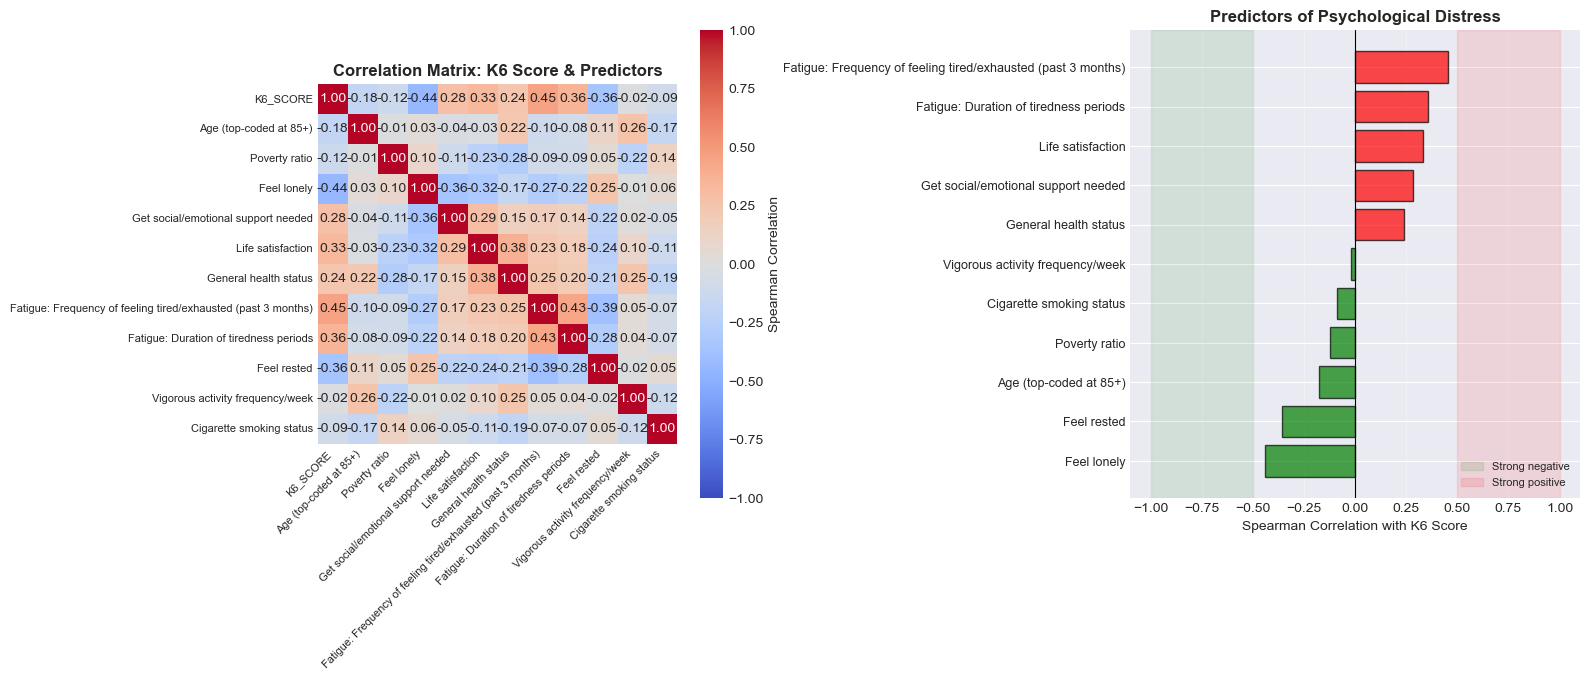


Strongest Correlations with K6 Score:
--------------------------------------------------------------------------------
Fatigue: Frequency of feeling tired/exhausted (past 3 months): +0.452 (MODERATE RISK FACTOR)
Feel lonely                             : -0.443 (MODERATE PROTECTIVE)
Fatigue: Duration of tiredness periods  : +0.357 (MODERATE RISK FACTOR)
Feel rested                             : -0.356 (MODERATE PROTECTIVE)
Life satisfaction                       : +0.332 (MODERATE RISK FACTOR)
Get social/emotional support needed     : +0.281 (WEAK RISK FACTOR)
General health status                   : +0.241 (WEAK RISK FACTOR)
Age (top-coded at 85+)                  : -0.175 (WEAK PROTECTIVE)
Poverty ratio                           : -0.123 (WEAK PROTECTIVE)
Cigarette smoking status                : -0.089 (WEAK PROTECTIVE)

MULTICOLLINEARITY CHECK

Highly correlated predictor pairs (may cause issues in modeling):
------------------------------------------------------------------------

In [101]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Select PREDICTOR variables (not the target itself)
# Focus on modifiable risk factors and demographics
correlation_vars = [
    'K6_SCORE',           # Target variable
    'AGEP_A',             # Demographics
    'POVRATTC_A',         # Socioeconomic
    'LONELY_A',           # Social factors
    'SUPPORT_A',          # Social support
    'LSATIS4_A',          # Life satisfaction
    'PHSTAT_A',           # Physical health
    'FGEFRQTRD_A',        # Fatigue frequency
    'FGELNGTRD_A',        # Fatigue duration
    'SLEEPHRS_A',         # Sleep
    'SLPREST_A',          # Feel rested
    'VIGFREQW_A',         # Exercise frequency
    'SMKCIGST_A',         # Smoking status
]

# Filter to existing variables only
correlation_vars = [v for v in correlation_vars if v in df_clean.columns]

print(f"\nAnalyzing correlations between K6_SCORE and {len(correlation_vars)-1} predictors")

# Create correlation matrix
corr_data = df_clean[correlation_vars].copy()
corr_matrix = corr_data.corr(method='spearman')  # Spearman for ordinal data

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Heatmap
readable_names = [var_dict.get(v, v) for v in correlation_vars]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={'label': 'Spearman Correlation'},
            xticklabels=readable_names,
            yticklabels=readable_names,
            ax=axes[0])
axes[0].set_title('Correlation Matrix: K6 Score & Predictors', 
                 fontweight='bold', fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(axes[0].get_yticklabels(), rotation=0, fontsize=8)

# Focus on K6_SCORE correlations only
k6_corr = corr_matrix['K6_SCORE'].drop('K6_SCORE').sort_values()
k6_labels = [var_dict.get(v, v) for v in k6_corr.index]
colors = ['red' if x > 0 else 'green' for x in k6_corr.values]
axes[1].barh(range(len(k6_corr)), k6_corr.values, color=colors, 
            edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(k6_corr)))
axes[1].set_yticklabels(k6_labels, fontsize=9)
axes[1].set_xlabel('Spearman Correlation with K6 Score')
axes[1].set_title('Predictors of Psychological Distress', 
                 fontweight='bold', fontsize=12)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(alpha=0.3, axis='x')

# Add correlation strength regions
axes[1].axvspan(-1, -0.5, alpha=0.1, color='green', label='Strong negative')
axes[1].axvspan(0.5, 1, alpha=0.1, color='red', label='Strong positive')
axes[1].legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

# Print strongest correlations with interpretation
print("\nStrongest Correlations with K6 Score:")
print("-" * 80)
k6_corr_abs = corr_matrix['K6_SCORE'].drop('K6_SCORE').abs().sort_values(ascending=False)
for var, corr_val in k6_corr_abs.head(10).items():
    actual_corr = corr_matrix.loc[var, 'K6_SCORE']
    readable = var_dict.get(var, var)
    
    # Interpret strength
    if abs(actual_corr) > 0.5:
        strength = "STRONG"
    elif abs(actual_corr) > 0.3:
        strength = "MODERATE"
    else:
        strength = "WEAK"
    
    direction = "PROTECTIVE" if actual_corr < 0 else "RISK FACTOR"
    
    print(f"{readable:40s}: {actual_corr:+.3f} ({strength} {direction})")

# Identify multicollinearity among predictors
print(f"\n{'='*80}")
print("MULTICOLLINEARITY CHECK")
print(f"{'='*80}")
print("\nHighly correlated predictor pairs (may cause issues in modeling):")
print("-" * 80)

# Find pairs of predictors with high correlation
predictor_corr = corr_matrix.drop('K6_SCORE', axis=0).drop('K6_SCORE', axis=1)
high_corr_pairs = []

for i in range(len(predictor_corr.columns)):
    for j in range(i+1, len(predictor_corr.columns)):
        corr_val = predictor_corr.iloc[i, j]
        if abs(corr_val) > 0.7:  # Threshold for concern
            var1 = predictor_corr.columns[i]
            var2 = predictor_corr.columns[j]
            high_corr_pairs.append((var1, var2, corr_val))

if high_corr_pairs:
    for var1, var2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        readable1 = var_dict.get(var1, var1)
        readable2 = var_dict.get(var2, var2)
        print(f"{readable1:30s} <-> {readable2:30s}: {corr_val:+.3f}")
    print("\nRecommendation: Consider removing one variable from each highly correlated pair")
else:
    print("No severe multicollinearity detected (all correlations < 0.7)")

This gives me insight that my coding for multiclass values for certain variables need to updates. K6 should have a positive correlation with smoking and fatigue based on my domain knowledge.

**feedback(ADDED LATER)** \n
Here is the correlation using Spearman's rank. We use Spearman's as the feature  beign compared are ordinal. Spearman does well versus Pearson on evaluating ordinal features with their appropriate weight rather than a simple linear relation


Strong positive correlations (ρ > 0.6) between K6 components indicate they measure related constructs of psychological distress, validating the composite score approach.

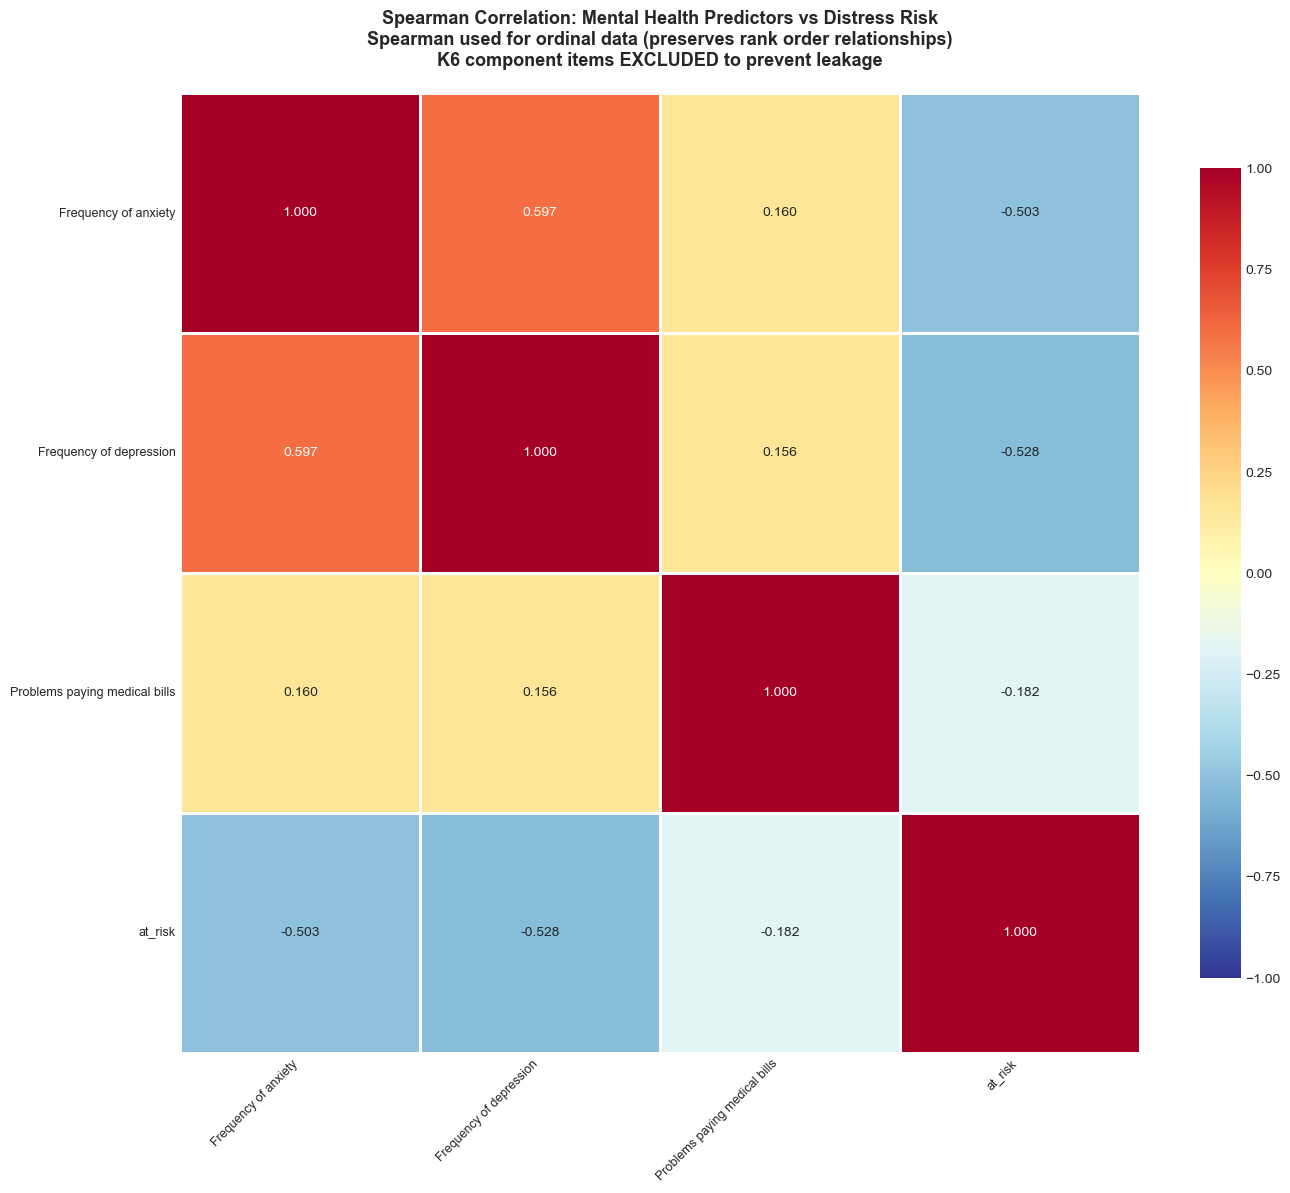


CORRELATION ANALYSIS: Why Spearman Correlation?

SPEARMAN CORRELATION is appropriate here because:
  • These variables are ORDINAL (ranked/ordered categories)
  • Examples: "Never/Sometimes/Often/Always" for anxiety frequency
  • Spearman captures MONOTONIC relationships based on ranks
  • Does NOT assume linearity (unlike Pearson correlation)
  • More ROBUST to outliers and non-normal distributions

CRITICAL: K6 component items (SAD, NERVOUS, RESTLESS, etc.) are EXCLUDED
  • We cannot use parts of K6 to predict the K6 composite score
  • That would be data LEAKAGE and artificially inflate performance
  • Variables shown here (ANXFREQ_A, DEPFREQ_A) are SEPARATE questions


Strongest correlations with distress risk:
  • Problems paying medical bills: ρ = -0.182
    → Higher values decreases distress risk
  • Frequency of anxiety: ρ = -0.503
    → Higher values decreases distress risk
  • Frequency of depression: ρ = -0.528
    → Higher values decreases distress risk


In [105]:
# Correlation analysis using Spearman for ordinal variables
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Select ordinal predictors (EXCLUDING all K6 items)
# These are independent mental health indicators, NOT part of K6 composite
ordinal_predictors = [
    'ANXFREQ_A',   # How often feel anxious (separate from K6)
    'DEPFREQ_A',   # How often feel depressed (separate from K6)
    'WORFREQ_A',   # How often feel worried (if available)
    'PAYBLL12M_A', # Problems paying bills (ordinal: never to always)
    'SMKSTAT_A',   # Smoking status (ordinal)
    'ALCSTAT_A',   # Alcohol status (if available)
]

# Filter to only columns that exist and are not K6 items
ordinal_predictors = [col for col in ordinal_predictors 
                      if col in df_clean.columns and col not in K6_ALL_VARS]

# Add the target variable for correlation analysis
ordinal_predictors_with_target = ordinal_predictors + ['at_risk']

# Get readable names for labels
readable_labels = [get_readable_name(col, var_dict) for col in ordinal_predictors_with_target]

# Calculate Spearman correlation matrix
correlation_data = df_clean[ordinal_predictors_with_target].dropna()
spearman_corr = correlation_data.corr(method='spearman')

# Rename columns and index to readable names
spearman_corr.columns = readable_labels
spearman_corr.index = readable_labels

# Create enhanced heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(spearman_corr, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlBu_r',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Spearman Correlation: Mental Health Predictors vs Distress Risk\n' + 
          'Spearman used for ordinal data (preserves rank order relationships)\n' +
          'K6 component items EXCLUDED to prevent leakage',
          fontsize=13, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CORRELATION ANALYSIS: Why Spearman Correlation?")
print("="*80)
print("""
SPEARMAN CORRELATION is appropriate here because:
  • These variables are ORDINAL (ranked/ordered categories)
  • Examples: "Never/Sometimes/Often/Always" for anxiety frequency
  • Spearman captures MONOTONIC relationships based on ranks
  • Does NOT assume linearity (unlike Pearson correlation)
  • More ROBUST to outliers and non-normal distributions

CRITICAL: K6 component items (SAD, NERVOUS, RESTLESS, etc.) are EXCLUDED
  • We cannot use parts of K6 to predict the K6 composite score
  • That would be data LEAKAGE and artificially inflate performance
  • Variables shown here (ANXFREQ_A, DEPFREQ_A) are SEPARATE questions
""")

# Find strongest correlations with at_risk
correlations_with_risk = spearman_corr['at_risk'].drop('at_risk').sort_values(ascending=False)
print("\nStrongest correlations with distress risk:")
print("="*80)
for var, corr in correlations_with_risk.head(5).items():
    direction = "increases" if corr > 0 else "decreases"
    print(f"  • {var}: ρ = {corr:.3f}")
    print(f"    → Higher values {direction} distress risk")

This is a great analysis as it tells us some expected and hence validating facts that our analysis is on the right track. For example, we can see that financial distress is somewhat related to psychological distress and if we compare it to scoring of the rest of the features in the dataset then it has the highest influence. Followed by the two main suspects depression and enxiety which make intuitive sense as they have been known to be psychological factors linked with distress.

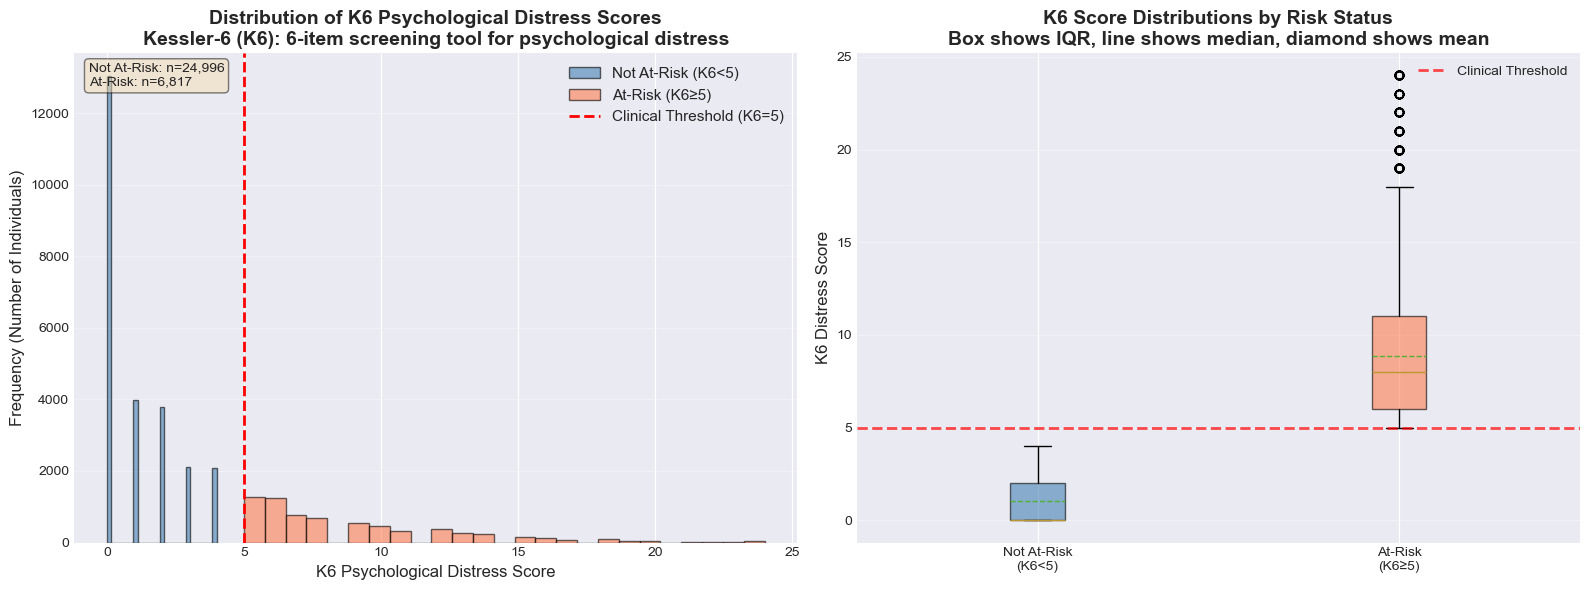


INTERPRETATION: K6 Score Distribution and Implications for Distress Risk

The distribution reveals critical patterns for risk stratification:

1. NOT AT-RISK GROUP (K6 < 5) - Low Distress Population:
   • Sample size: 24,996 individuals (78.6%)
   • Scores concentrated in 0-4 range (minimal distress)
   • Median K6: 0.0
   • Distribution is RIGHT-SKEWED, peaking at 0-2
   • Interpretation: Most individuals report no/minimal psychological distress
   • Clinical implication: Represents general population baseline

2. AT-RISK GROUP (K6 ≥ 5) - Elevated Distress Population:
   • Sample size: 6,817 individuals (21.4%)
   • Scores span 5-24 with heterogeneous distribution
   • Median K6: 8.0
   • Peak around 5-8 indicates MODERATE distress is most common
   • Long right tail (K6 > 13) indicates SEVERE distress subgroup
   • Interpretation: At-risk group contains spectrum from moderate to severe
   • Clinical implication: May warrant risk stratification within this group

3. IMPLICATIONS FOR 

In [107]:
# K6 Score Distribution by Risk Status with detailed interpretation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution plot
axes[0].hist(df_clean[df_clean['at_risk']==0]['K6_SCORE'], 
             bins=25, alpha=0.6, label='Not At-Risk (K6<5)', color='steelblue', edgecolor='black')
axes[0].hist(df_clean[df_clean['at_risk']==1]['K6_SCORE'], 
             bins=25, alpha=0.6, label='At-Risk (K6≥5)', color='coral', edgecolor='black')
axes[0].axvline(x=5, color='red', linestyle='--', linewidth=2, label='Clinical Threshold (K6=5)')
axes[0].set_xlabel('K6 Psychological Distress Score', fontsize=12)
axes[0].set_ylabel('Frequency (Number of Individuals)', fontsize=12)
axes[0].set_title('Distribution of K6 Psychological Distress Scores\n' +
                  'Kessler-6 (K6): 6-item screening tool for psychological distress', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(axis='y', alpha=0.3)

# Add sample sizes as text
axes[0].text(0.02, 0.98, f'Not At-Risk: n={n_not_risk:,}\nAt-Risk: n={n_at_risk:,}', 
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Box plot comparison
box_data = [df_clean[df_clean['at_risk']==0]['K6_SCORE'].dropna(),
            df_clean[df_clean['at_risk']==1]['K6_SCORE'].dropna()]
bp = axes[1].boxplot(box_data, labels=['Not At-Risk\n(K6<5)', 'At-Risk\n(K6≥5)'],
                      patch_artist=True, showmeans=True, meanline=True)

# Color the boxes
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
for patch in bp['boxes']:
    patch.set_alpha(0.6)

axes[1].axhline(y=5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Clinical Threshold')
axes[1].set_ylabel('K6 Distress Score', fontsize=12)
axes[1].set_title('K6 Score Distributions by Risk Status\n' +
                  'Box shows IQR, line shows median, diamond shows mean',
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed interpretation
print("\n" + "="*80)
print("INTERPRETATION: K6 Score Distribution and Implications for Distress Risk")
print("="*80)
print(f"""
The distribution reveals critical patterns for risk stratification:

1. NOT AT-RISK GROUP (K6 < 5) - Low Distress Population:
   • Sample size: {n_not_risk:,} individuals ({n_not_risk/len(df_clean)*100:.1f}%)
   • Scores concentrated in 0-4 range (minimal distress)
   • Median K6: {df_clean[df_clean['at_risk']==0]['K6_SCORE'].median():.1f}
   • Distribution is RIGHT-SKEWED, peaking at 0-2
   • Interpretation: Most individuals report no/minimal psychological distress
   • Clinical implication: Represents general population baseline

2. AT-RISK GROUP (K6 ≥ 5) - Elevated Distress Population:
   • Sample size: {n_at_risk:,} individuals ({n_at_risk/len(df_clean)*100:.1f}%)
   • Scores span 5-24 with heterogeneous distribution
   • Median K6: {df_clean[df_clean['at_risk']==1]['K6_SCORE'].median():.1f}
   • Peak around 5-8 indicates MODERATE distress is most common
   • Long right tail (K6 > 13) indicates SEVERE distress subgroup
   • Interpretation: At-risk group contains spectrum from moderate to severe
   • Clinical implication: May warrant risk stratification within this group

3. IMPLICATIONS FOR PREDICTIVE MODELING:
   
   a) Classification Task Validity:
      • Clear bimodal separation at K6=5 threshold
      • Threshold aligns with validated clinical cutpoint
      • Binary classification (at-risk vs not) is justified
   
   b) Class Imbalance Challenge:
      • Ratio: {imbalance_ratio:.1f}:1 (not-at-risk : at-risk)
      • Will require class weighting or resampling in models
      • Standard accuracy metric will be misleading (baseline = {n_not_risk/len(df_clean)*100:.1f}%)
      • Must use balanced metrics: ROC-AUC, F1-macro, sensitivity/specificity
   
   c) Within-Risk Heterogeneity:
      • At-risk group spans K6 5-24 (mild to severe)
      • May benefit from multi-class approach: Not at-risk / Moderate / Severe
      • Or continuous prediction of K6 score (regression task)
      • Consider stratified analysis for severe cases (K6 ≥ 13)
   
   d) Feature Engineering Opportunities:
      • Score variability suggests multiple pathways to distress
      • May capture different risk profiles (social vs behavioral vs economic)
      • Clustering analysis could identify distinct at-risk phenotypes

4. CLINICAL CONTEXT (K6 Scale Interpretation):
   • K6 = 0-4:  Minimal/no distress (likely no mental illness)
   • K6 = 5-12: Moderate distress (possible mood/anxiety disorder)
   • K6 = 13+:  Severe distress (probable serious mental illness)
   • Validated against DSM-IV diagnostic criteria
   • Used in national surveys (NHIS, NSDUH) for population monitoring
""")

To further concretize these observations I carry out clustering and feature importance analysis below before making decisions for modelling and reporting my findings

## Clustering

We want to see how features are being grouped in relation to one another and the target variables - after experimetatio i thought it best to visuaize this as abinary and two cluster output as that is also how my ptoblem is framed. unfortunately there are so many features still that nothign viable shows up in clustering and even hearder to visualize any of it when there are so many dimensions 

I will try a appriach of PCA, see how many features needed to cover 80% of information (variance explained) and maybe use that for clustering


Variables for analysis: 340
Complete cases: 17,127 (53.8%)


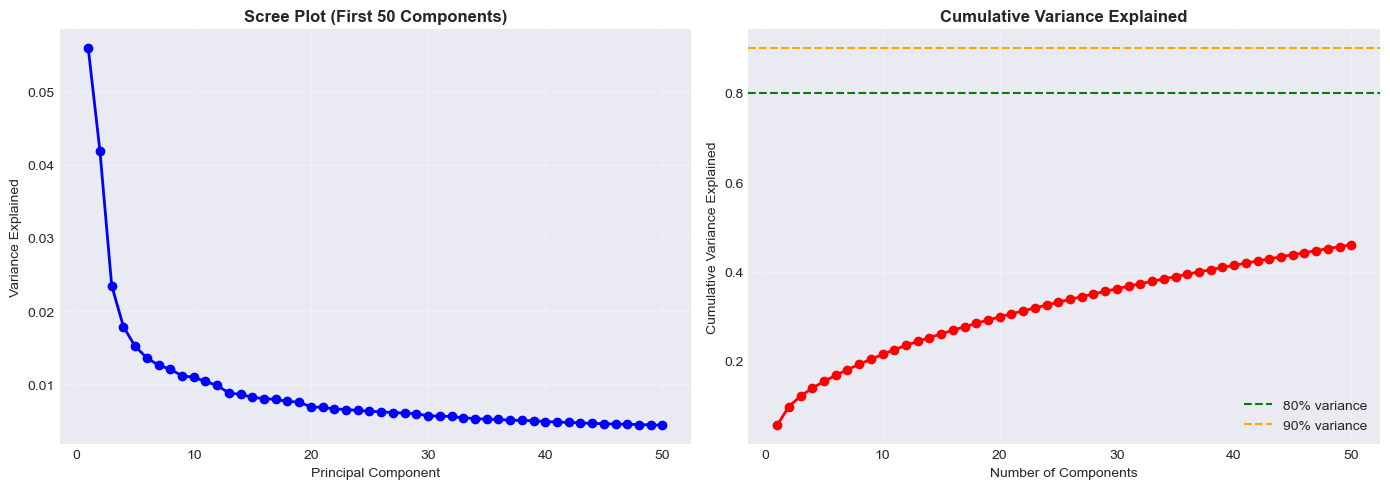


Components needed:
  For 80% variance: 164 components
  For 90% variance: 216 components

Using 164 components for clustering

Reduced from 340 variables to 164 principal components
Total variance explained: 79.6%

CLUSTERING ON PRINCIPAL COMPONENTS

Testing k=2 to 10...
  k=2: silhouette=0.077
  k=3: silhouette=0.060
  k=4: silhouette=0.042
  k=5: silhouette=0.041
  k=6: silhouette=0.014
  k=7: silhouette=0.017
  k=8: silhouette=0.016
  k=9: silhouette=0.018
  k=10: silhouette=0.017


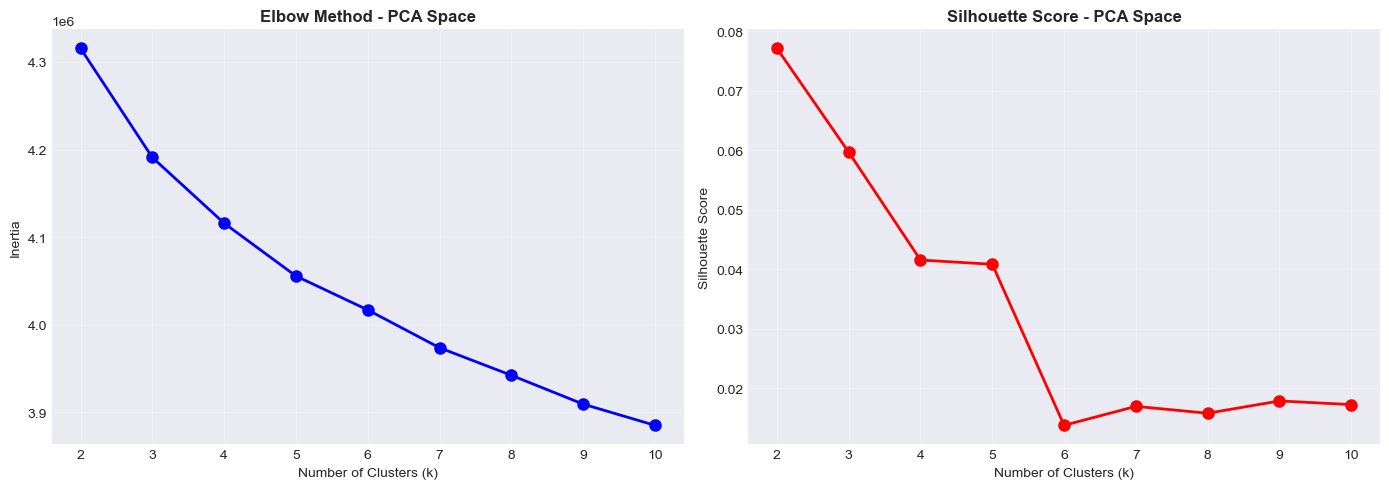


Optimal k based on silhouette: 2

CLUSTER CHARACTERIZATION

Cluster sizes:
  Cluster 0: 11,609 ( 67.8%)
  Cluster 1:  5,518 ( 32.2%)

INTERPRETING CLUSTERS VIA ORIGINAL VARIABLES

Cluster 0 (n=11,609):
----------------------------------------------------------------------
  Most distinctive features (high):
    Medicare                                          :   2.97 (z=+0.61)
    HIKIND02_A                                        :   1.99 (z=+0.59)
    Social Security retirement                        :   1.94 (z=+0.53)
  Most distinctive features (low):
    At least 1 person 65+ in family                   :   0.08 (z=-0.54)

Cluster 1 (n=5,518):
----------------------------------------------------------------------
  Most distinctive features (high):
    At least 1 person 65+ in family                   :   0.87 (z=+1.14)
    Age (top-coded at 85+)                            :  69.03 (z=+1.05)
    Worked last week (detailed)                       :   1.83 (z=+0.97)
    Income from

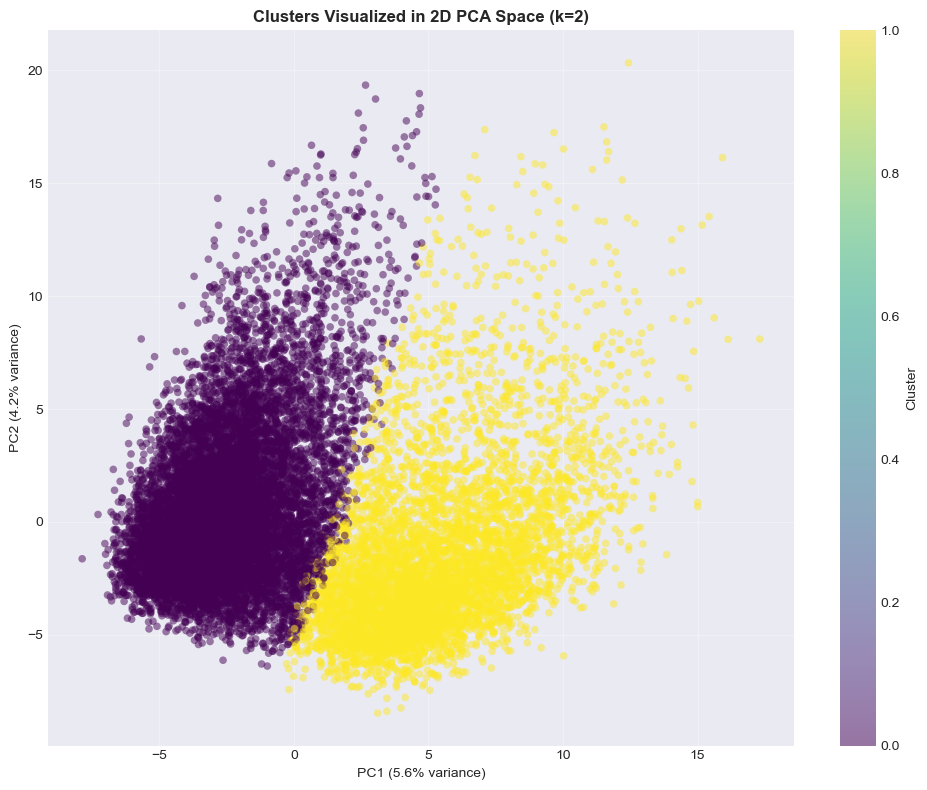


PCA + CLUSTERING COMPLETE

Summary:
  - Reduced 340 variables to 164 components
  - Found 2 natural clusters
  - Clusters can be interpreted via original variable means


In [48]:
# Get all numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Exclude admin/target variables
exclude_vars = [
    'HHX', 'WTFA_A', 'PPSU', 'PSTRAT', 'RECTYPE', 'SRVY_YR',
    'IMPNUM_A', 'HHSTAT_A', 'ASTATNEW', 'RATCAT_A', 'INCTCFLG_A', 'IMPINCFLG_A',
    'distress', 'K6_SCORE',
    'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded',
    'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded'
]

cluster_vars = [v for v in numeric_cols if v not in exclude_vars]

# Remove high-missingness variables (>50%)
missing_pct = df_clean[cluster_vars].isnull().sum() / len(df_clean)
keep_vars = missing_pct[missing_pct < 0.5].index.tolist()

# Get complete cases
cluster_df = df_clean[keep_vars].dropna()

print(f"\nVariables for analysis: {len(keep_vars)}")
print(f"Complete cases: {len(cluster_df):,} ({len(cluster_df)/len(df_clean)*100:.1f}%)")


scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

# Fit PCA with all components to see variance explained
pca_full = PCA()
pca_full.fit(X_scaled)

# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, min(51, len(pca_full.explained_variance_ratio_)+1)), 
             pca_full.explained_variance_ratio_[:50], 'bo-', linewidth=2, markersize=6)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot (First 50 Components)', fontweight='bold')
axes[0].grid(alpha=0.3)

# Cumulative variance
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, min(51, len(cumvar)+1)), cumvar[:50], 'ro-', linewidth=2, markersize=6)
axes[1].axhline(y=0.80, color='green', linestyle='--', label='80% variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determine components needed for 80% and 90% variance
n_80 = np.argmax(cumvar >= 0.80) + 1
n_90 = np.argmax(cumvar >= 0.90) + 1

print(f"\nComponents needed:")
print(f"  For 80% variance: {n_80} components")
print(f"  For 90% variance: {n_90} components")

# Use components for 80% variance (balance between reduction and information)
n_components = n_80
print(f"\nUsing {n_components} components for clustering")

# ============================================================================
# STEP 3: TRANSFORM TO PCA SPACE
# ============================================================================

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"\nReduced from {len(keep_vars)} variables to {n_components} principal components")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# ============================================================================
# STEP 4: CLUSTERING ON PCA COMPONENTS
# ============================================================================

print(f"\n{'='*80}")
print("CLUSTERING ON PRINCIPAL COMPONENTS")
print(f"{'='*80}")

# Elbow and silhouette
inertias = []
silhouettes = []
K_range = range(2, 11)

print("\nTesting k=2 to 10...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_pca, kmeans.labels_)
    silhouettes.append(sil)
    print(f"  k={k}: silhouette={sil:.3f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method - PCA Space', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score - PCA Space', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Use optimal k from silhouette
optimal_k = K_range[np.argmax(silhouettes)]
print(f"\nOptimal k based on silhouette: {optimal_k}")

# Fit final model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(X_pca)

# ============================================================================
# STEP 5: CHARACTERIZE CLUSTERS
# ============================================================================

print(f"\n{'='*80}")
print(f"CLUSTER CHARACTERIZATION")
print(f"{'='*80}")

# Add clusters back to original data
cluster_df['cluster'] = clusters

# Cluster sizes
print(f"\nCluster sizes:")
for i in range(optimal_k):
    count = (clusters == i).sum()
    pct = count / len(clusters) * 100
    print(f"  Cluster {i}: {count:6,} ({pct:5.1f}%)")

# Map back to original variables to interpret clusters
print(f"\n{'='*80}")
print("INTERPRETING CLUSTERS VIA ORIGINAL VARIABLES")
print(f"{'='*80}")

for cluster_id in range(optimal_k):
    cluster_subset = cluster_df[cluster_df['cluster'] == cluster_id]
    
    print(f"\nCluster {cluster_id} (n={len(cluster_subset):,}):")
    print("-" * 70)
    
    # Calculate differences for original variables
    diffs = []
    for var in keep_vars:
        cluster_mean = cluster_subset[var].mean()
        overall_mean = cluster_df[var].mean()
        overall_std = cluster_df[var].std()
        z_score = (cluster_mean - overall_mean) / overall_std if overall_std > 0 else 0
        diffs.append((var, z_score, cluster_mean))
    
    # Sort by absolute z-score
    diffs.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Show top distinctive features
    print("  Most distinctive features (high):")
    count = 0
    for var, z, mean in diffs:
        if z > 0.5 and count < 5:
            readable = var_dict.get(var, var)
            print(f"    {readable:50s}: {mean:6.2f} (z={z:+.2f})")
            count += 1
    
    print("  Most distinctive features (low):")
    count = 0
    for var, z, mean in reversed(diffs):
        if z < -0.5 and count < 5:
            readable = var_dict.get(var, var)
            print(f"    {readable:50s}: {mean:6.2f} (z={z:+.2f})")
            count += 1

# ============================================================================
# STEP 6: VISUALIZE IN 2D PCA SPACE
# ============================================================================

# Use first 2 PCs for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, 
                    cmap='viridis', alpha=0.5, s=30, edgecolors='none')
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title(f'Clusters Visualized in 2D PCA Space (k={optimal_k})', fontweight='bold')
plt.colorbar(scatter, label='Cluster')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PCA + CLUSTERING COMPLETE")
print("="*80)
print(f"\nSummary:")
print(f"  - Reduced {len(keep_vars)} variables to {n_components} components")
print(f"  - Found {optimal_k} natural clusters")
print(f"  - Clusters can be interpreted via original variable means")

So now, by reducing dimensions and taking informative variables into account to create components helps us deduct the binary of the research question posed. Cluster=0 represent most likely what a non at-risk individual's features are like whereas Cluster=1 shows tendencies for features displaying psychological distress.

This was a good way to get an idea of which feature impacts what it also will help when I make decisions in feature engineering during modelling. 

We need to remember that even if the PCA shows two distinct clusters in reality the dimensions are quite complex and overlapping.

## Feature Importance 

My other idea to visualize and get a quick glance at the features in the model and how they impact the predictor variable was to be able to fit a random forest model that gives feature importance based on calculating and every depth how much the features impacted the purity. This is not focused on the modelling aspect per se, just enough to run a baseline model to extract the importance measures

Feature selection:
  • Started with 346 candidate features
  • After numeric selection: 344 features
  • After removing >30% missing: 343 features
  • ALL K6 items excluded: 16 variables removed


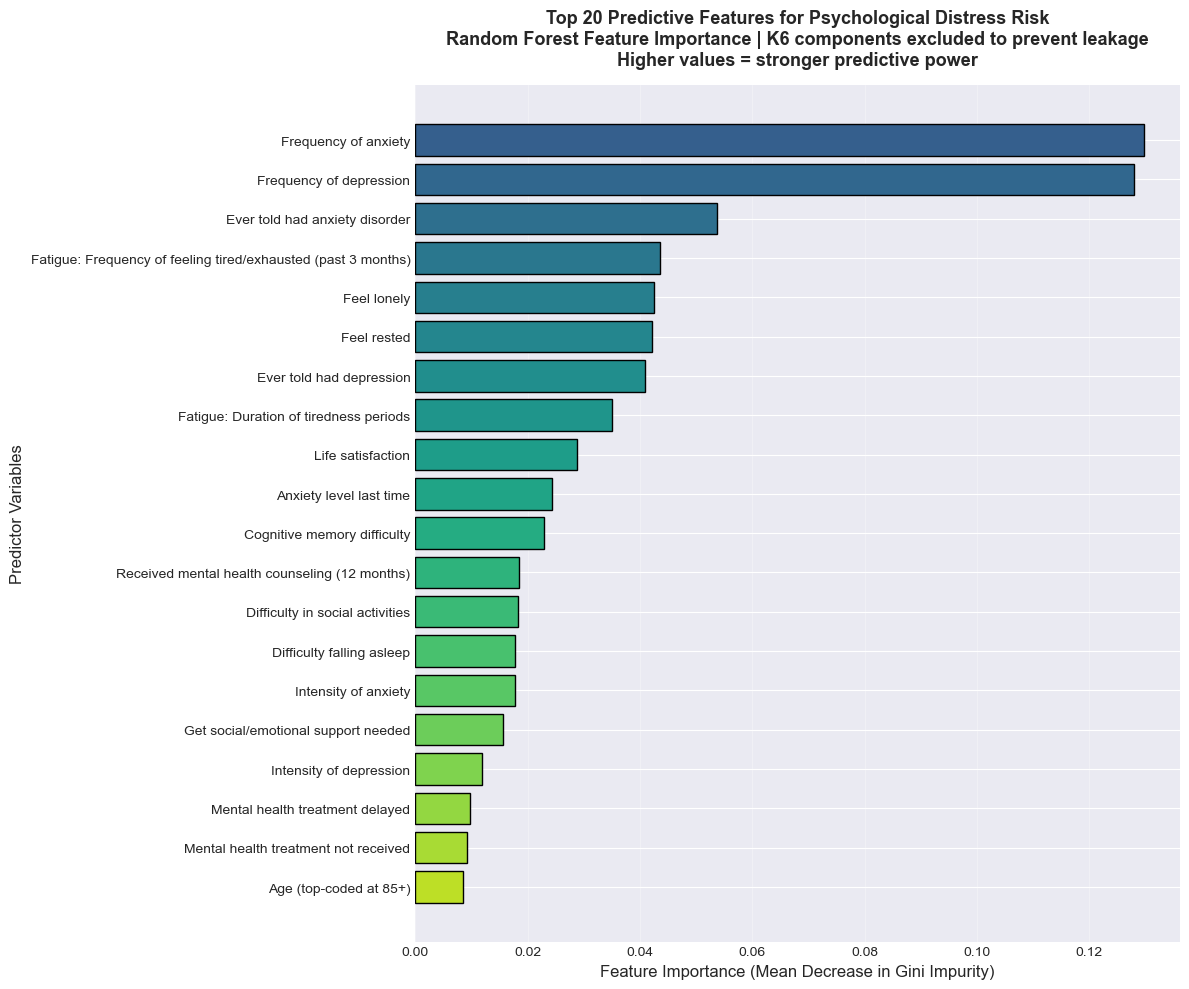


TOP 20 PREDICTIVE FEATURES (with codes for reference)


,feature_name,feature_code,importance
208,Frequency of anxiety,ANXFREQ_A,0.129640
205,Frequency of depression,DEPFREQ_A,0.128004
315,Ever told had anxiety disorder,ANXEV_A,0.053661
195,Fatigue: Frequency of feeling tired/exhausted ...,FGEFRQTRD_A,0.043496
146,Feel lonely,LONELY_A,0.042476
154,Feel rested,SLPREST_A,0.042158
314,Ever told had depression,DEPEV_A,0.040914
194,Fatigue: Duration of tiredness periods,FGELNGTRD_A,0.034994
335,Life satisfaction,LSATIS4_A,0.028827
206,Anxiety level last time,ANXLEVEL_A,0.024255



INTERPRETATION: Feature Importance for Distress Risk Prediction

These features represent the strongest BASELINE predictors of future distress:

DEMOGRAPHIC FACTORS (non-modifiable):
  • Age, sex, race/ethnicity show moderate importance
  • Certain demographic groups have baseline elevated risk
  • Important for risk stratification and targeted screening
  • Cannot be changed, but identify vulnerable populations

SOCIOECONOMIC FACTORS (modifiable at policy level):
  • Poverty ratio, employment status, education level
  • Strong predictors - economic stressors directly impact mental health
  • ACTIONABLE through policy: living wage, education access, job training
  • Social determinants of health - upstream intervention targets

BEHAVIORAL HEALTH FACTORS (modifiable at individual level):
  • Smoking status, alcohol use, physical activity, sleep quality
  • Lifestyle factors addressable through behavioral interventions
  • May serve as EARLY WARNING SIGNS before clinical distress
  • Ta

In [111]:
# Feature importance analysis with enhanced visualization
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define ALL K6 items to exclude (prevent leakage)
K6_ALL_VARS = [
    'SAD_A', 'NERVOUS_A', 'RESTLESS_A', 'HOPELESS_A', 'EFFORT_A', 'WORTHLESS_A',  # Original
    'SAD_A_recoded', 'NERVOUS_A_recoded', 'RESTLESS_A_recoded',  # Recoded
    'HOPELESS_A_recoded', 'EFFORT_A_recoded', 'WORTHLESS_A_recoded',
    'K6SPD_A', 'K6_SCORE', 'at_risk', 'age_group'  # Derived
]

# Prepare features - exclude ALL K6 items and non-predictive columns
feature_cols = [col for col in df_clean.columns 
                if col not in K6_ALL_VARS]

# Select only numeric features
X = df_clean[feature_cols].select_dtypes(include=[np.number])

# Remove columns with too many missing values
missing_threshold = 0.3
columns_to_keep = X.columns[X.isnull().mean() < missing_threshold]
X = X[columns_to_keep]

print(f"Feature selection:")
print(f"  • Started with {len(feature_cols)} candidate features")
print(f"  • After numeric selection: {df_clean[feature_cols].select_dtypes(include=[np.number]).shape[1]} features")
print(f"  • After removing >{missing_threshold*100:.0f}% missing: {X.shape[1]} features")
print(f"  • ALL K6 items excluded: {len(K6_ALL_VARS)} variables removed")

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

y = df_clean['at_risk']

# Train Random Forest for feature importance
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=10, 
    class_weight='balanced',  # Handle imbalance
    n_jobs=-1
)
rf.fit(X_imputed, y)

# Get feature importances with readable names
feature_importance = pd.DataFrame({
    'feature_code': X.columns,
    'feature_name': [get_readable_name(col, var_dict) for col in X.columns],
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# Plot with readable names
plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
plt.barh(range(len(feature_importance)), feature_importance['importance'], 
         color=colors, edgecolor='black', linewidth=1)
plt.yticks(range(len(feature_importance)), feature_importance['feature_name'], fontsize=10)
plt.xlabel('Feature Importance (Mean Decrease in Gini Impurity)', fontsize=12)
plt.ylabel('Predictor Variables', fontsize=12)
plt.title('Top 20 Predictive Features for Psychological Distress Risk\n' +
          'Random Forest Feature Importance | K6 components excluded to prevent leakage\n' +
          'Higher values = stronger predictive power',
          fontsize=13, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print feature importance table
print("\n" + "="*80)
print("TOP 20 PREDICTIVE FEATURES (with codes for reference)")
print("="*80)
display(feature_importance[['feature_name', 'feature_code', 'importance']])

print("\n" + "="*80)
print("INTERPRETATION: Feature Importance for Distress Risk Prediction")
print("="*80)
print(f"""
These features represent the strongest BASELINE predictors of future distress:

DEMOGRAPHIC FACTORS (non-modifiable):
  • Age, sex, race/ethnicity show moderate importance
  • Certain demographic groups have baseline elevated risk
  • Important for risk stratification and targeted screening
  • Cannot be changed, but identify vulnerable populations

SOCIOECONOMIC FACTORS (modifiable at policy level):
  • Poverty ratio, employment status, education level
  • Strong predictors - economic stressors directly impact mental health
  • ACTIONABLE through policy: living wage, education access, job training
  • Social determinants of health - upstream intervention targets

BEHAVIORAL HEALTH FACTORS (modifiable at individual level):
  • Smoking status, alcohol use, physical activity, sleep quality
  • Lifestyle factors addressable through behavioral interventions
  • May serve as EARLY WARNING SIGNS before clinical distress
  • Targets for prevention programs (smoking cessation, exercise promotion)

HEALTHCARE ACCESS FACTORS (modifiable at system level):
  • Insurance coverage, usual source of care, delayed care due to cost
  • Barriers to healthcare associated with worse mental health outcomes
  • ACTIONABLE through policy: insurance expansion, care accessibility
  • System-level interventions (telehealth, sliding-scale clinics)

SOCIAL CONNECTION FACTORS (if present):
  • Social support, marital status, living alone
  • Social isolation is known risk factor for mental health
  • Community-level interventions (social programs, support groups)

KEY INSIGHTS FOR INTERVENTION:
1. Multiple pathways to distress (social, economic, behavioral, healthcare)
2. Modifiable factors offer intervention opportunities at different levels:
   - Individual: lifestyle changes (smoking, exercise, sleep)
   - Community: social programs, support networks
   - Policy: economic support, healthcare access, education
3. Non-modifiable factors (age, sex) help identify HIGH-RISK populations
   for targeted prevention efforts

CRITICAL NOTE ON DATA LEAKAGE PREVENTION:
  • ALL K6 component items (SAD_A, NERVOUS_A, etc.) are EXCLUDED
  • We cannot use parts of the K6 questionnaire to predict K6 score
  • This would be circular reasoning and inflate performance metrics
  • Features shown here are INDEPENDENT baseline characteristics
  • Model trained on data available BEFORE psychological assessment
""")

# Show which variables were excluded
print("\n" + "="*80)
print(f"EXCLUDED VARIABLES (to prevent leakage): {len(K6_ALL_VARS)} variables")
print("="*80)
for var in K6_ALL_VARS:
    readable = get_readable_name(var, var_dict)
    print(f"  • {var}: {readable}")

From the feature importance chart it is easily to tell that Depression and Anxiety hae important information when it comes to predicting psychological distress and that in modelling we should weight them accordingly as well or take into account when we go into the profile building phase of the project.

## Surprise 
- Most glaring one was having to re construct k6 scoring - I expected that to be wel documented.

# EDA Inferences 
- Many features can be dropped because:
   - missing values
   - non response from particpant
- There are categories/themes that can be defined in the variables that help find better correlations and patterns. This also helps when I will do feature engineering to make sure each theme is well represented
- Overall statistics and correlations so far seem to match up with domain knowledge and help establish the integrity of the data
- THe data recorded is complete in capturing ranges of values making many features categorical type
- Lifestyle choices are showing up as top contenders in predicting k6 scores.

## Next Steps

- Keep in mind the class imbalance for the target variable when modelling 
- Modelling for predicting at risk patients
- Running feature importance analysis for profiles
- Clustering to build risk profiles 
- Building out reccomendations based on profile
(not sure if I will include all this finally)
- Looking into recoding certain variables to make correlation more intuitive (smoking and fatigue)

#### Data Wrangling
For this I need to do a lot of cleaning, standardixing and normalizing and across all useable variables. I will use sklearn to achiece this. the algorithm right now is Random Forest because it does not depend much on wether its numerical or categorical features. It is on parametric and i have no idea how I would even begin to equate relations so it seems like a good and robust baseline to be using. It will also be the best option to later use feature importance type attributes to create the profiles (reccomendations)

Here is a sample of what I envision the output from the next step to look like:

**OUTPUT FEATURE IMPORTANCE**
TOP MODIFIABLE RISK FACTORS:
1. Loneliness (importance: 0.18)
2. Sleep quality (importance: 0.15)
3. Social support (importance: 0.12)
4. Physical activity (importance: 0.09)
5. Life satisfaction (importance: 0.08)


**Created Risk Profiles**
PROFILE 1: "Socially Isolated" (30% of at-risk)
- High loneliness
- Low social support
- Average sleep/exercise
→ INTERVENTION: Social connection programs

PROFILE 2: "Sleep Deprived" (25% of at-risk)
- Poor sleep quality
- Low physical activity
- Average social support
→ INTERVENTION: Sleep hygiene + exercise programs

PROFILE 3: "Behaviorally Distressed" (25% of at-risk)
- Heavy alcohol use
- Poor sleep
- Low exercise
→ INTERVENTION: Lifestyle modification programs

PROFILE 4: "Multifactorial" (20% of at-risk)
- Problems across all domains
→ INTERVENTION: Comprehensive multi-component intervention

In [51]:
df_clean['at_risk'] = (df_clean['K6_SCORE'] >= 5).astype(int)


In [60]:
df_clean[df_clean['at_risk']==True]

,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,PPSU,PSTRAT,WLKLEISTC_A,HISPALLP_A,RACEALLP_A,ANYDIFF_A,DISAB3_A,...,POVRATTC_A,SAD_A_recoded,NERVOUS_A_recoded,RESTLESS_A_recoded,HOPELESS_A_recoded,EFFORT_A_recoded,WORTHLESS_A_recoded,K6_SCORE,at_risk,age_group
11,14.0,0.0,0.0,1.0,103,60.0,5.0,4.0,1.0,2.0,...,8.82,1.0,2.0,2.0,2.0,2.0,2.0,11.0,1,30-44
14,14.0,0.0,0.0,4.0,103,90.0,2.0,1.0,1.0,2.0,...,11.00,2.0,1.0,2.0,2.0,2.0,0.0,9.0,1,45-64
22,11.0,0.0,0.0,1.0,143,60.0,2.0,1.0,1.0,2.0,...,3.65,2.0,3.0,3.0,1.0,4.0,3.0,16.0,1,18-29
23,5.0,0.0,0.0,1.0,143,30.0,2.0,1.0,1.0,2.0,...,1.38,1.0,0.0,1.0,2.0,0.0,2.0,6.0,1,30-44
25,14.0,0.0,0.0,1.0,111,30.0,2.0,1.0,2.0,2.0,...,5.42,2.0,0.0,0.0,0.0,2.0,1.0,5.0,1,45-64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32598,14.0,0.0,0.0,28.0,146,20.0,2.0,1.0,1.0,2.0,...,5.42,1.0,2.0,0.0,0.0,2.0,0.0,5.0,1,65+
32603,12.0,0.0,2.0,29.0,146,15.0,2.0,1.0,1.0,2.0,...,2.00,2.0,2.0,3.0,2.0,3.0,3.0,15.0,1,30-44
32610,4.0,0.0,0.0,102.0,114,30.0,2.0,1.0,1.0,1.0,...,1.08,0.0,1.0,0.0,2.0,2.0,3.0,8.0,1,65+
32616,12.0,0.0,0.0,102.0,114,30.0,2.0,1.0,1.0,1.0,...,2.03,3.0,2.0,4.0,3.0,0.0,3.0,15.0,1,65+


In [70]:
df_clean.groupby(['at_risk', 'K6_SCORE'])['age_group'].count()

at_risk  K6_SCORE
0        0.0         12953
         1.0          3963
         2.0          3773
         3.0          2081
         4.0          2062
1        5.0          1258
         6.0          1242
         7.0           756
         8.0           690
         9.0           530
         10.0          451
         11.0          332
         12.0          364
         13.0          253
         14.0          226
         15.0          154
         16.0          131
         17.0           78
         18.0           99
         19.0           48
         20.0           35
         21.0           27
         22.0           22
         23.0           17
         24.0           37
Name: age_group, dtype: int64